# Plot Raw Power by BDI
Created: 07/31/24 \
Updated: XX/XX/2024 \



In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp, pearsonr, spearmanr
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.mixed_linear_model import MixedLM 
from joblib import Parallel, delayed
import pickle
import itertools
import time 
from matplotlib.ticker import StrMethodFormatter



import warnings
warnings.filterwarnings('ignore')




In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Specify root directory for un-archived data and results 
base_dir   = '/sc/arion/projects/guLab/Alie/SWB/'
anat_dir   = f'{base_dir}ephys_analysis/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir  = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'
save_dir   = f'{base_dir}ephys_analysis/results/regression_data/'
script_dir = '/hpc/users/finka03/swb_ephys_analysis/scripts/'

date = datetime.date.today().strftime('%m%d%Y')
print(date)

07312024


In [4]:
import sys
sys.path.append(f'{base_dir}ephys_analysis/LFPAnalysis/')

from LFPAnalysis import analysis_utils

sys.path.append(f'{script_dir}analysis_notebooks/')

from ieeg_tools import *

In [5]:
subj_ids = list(pd.read_excel(f'{base_dir}ephys_analysis/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[0]).PatientID)
n_subj = len(subj_ids)
# subj_ids


In [6]:
bdi_list = pd.read_excel(f'{base_dir}ephys_analysis/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[3])
bdi_list = list(bdi_list.SWB_BDI)
subj_info_df = pd.DataFrame({'subj_id':subj_ids,'bdi':bdi_list})
subj_info_df



subj_id  bdi
0    MS002   14
1    MS003    8
2    MS009   16
3    MS011   13
4    MS015   26
5    MS016   10
6    MS017   26
7    MS019   12
8    MS022   10
9    MS024   16
10   MS025   10
11   MS026    9
12   MS027   22
13   MS028   13
14   MS029   32
15   MS030   19
16   MS033   39
17   MS035   15
18   MS041   10
19   MS043   23
20   MS048   19
21   MS050    9
22     DA8   13
23   DA023   14
24   DA026   19
25   DA037    4
26   DA039   22

In [27]:
#### Try Beta Power 
all_subj_beta_power = {}
all_subj_metadata   = {}

beta_range = [13,30]

# load pow epochs data 
for subj_id in subj_ids: 
    # load power epochs for single subject 
    power_epochs = mne.time_frequency.read_tfrs(f'{neural_dir}{subj_id}/{subj_id}_CpeOnset-tfr.h5')[0]
    power_epochs = power_epochs.crop(tmin=0,tmax=2.0,include_tmax=True)
    all_subj_metadata[subj_id] = power_epochs.metadata.copy()
    
    # extract power df with mean beta power for each epoch for each elec 
    power_df = power_epochs.to_data_frame()
    del power_epochs 
    beta_power_df = power_df[(power_df.freq >= beta_range[0])&(power_df.freq <= beta_range[1])].groupby(['epoch']).agg('mean').reset_index()
    del power_df 
    all_subj_beta_power[subj_id] = beta_power_df
    del beta_power_df
    
    
# create a binary pickle file 
pickle.dump(all_subj_beta_power,open(f'{save_dir}all_subj_beta_power_2sec.pkl',"wb"))
# pickle.dump(all_subj_metadata,open(f'{save_dir}all_subj_metadata.pkl',"wb"))

    

Reading /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS002/MS002_CpeOnset-tfr.h5 ...
Adding metadata with 19 columns
Reading /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS003/MS003_CpeOnset-tfr.h5 ...
Adding metadata with 19 columns
Reading /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS009/MS009_CpeOnset-tfr.h5 ...
Adding metadata with 19 columns
Reading /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS011/MS011_CpeOnset-tfr.h5 ...
Adding metadata with 19 columns
Reading /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS015/MS015_CpeOnset-tfr.h5 ...
Adding metadata with 19 columns
Reading /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS016/MS016_CpeOnset-tfr.h5 ...
Adding metadata with 19 columns
Reading /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS017/MS017_CpeOnset-tfr.h5 ...
Adding metadata with 19 columns
Reading /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS019/MS019_CpeOnset-tfr.h5 ...
Adding metadata with 19 

In [ ]:
# # load newest file
# paths = glob(f'{save_dir}all_subj_beta_power_*.csv')
# load_date = str(np.max([int(path.split('_')[-1][:-4]) # find most recent saved df to load 
#                         for path in paths]))

# all_subj_beta_power = pickle.load(open(f'{save_dir}all_subj_beta_power_0{load_date}.pkl',"rb"))

# all_subj_beta_power = pickle.load(open(f'{save_dir}all_subj_beta_power.pkl',"rb"))
# all_subj_beta_power

# Create Beta Regression Data

In [ ]:
# metadata_paths = glob(f'{save_dir}all_subj_metadata_*.pkl')
# load_date = str(np.max([int(path.split('_')[-1][:-4]) # find most recent saved df to load 
#                         for path in metadata_paths]))
# all_subj_metadata = pickle.load(open(f'{save_dir}all_subj_metadata_0{load_date}.pkl','rb'))

# all_subj_metadata = pickle.load(open(f'{save_dir}all_subj_metadata.pkl','rb'))
# all_subj_metadata

In [28]:
### update metadata - zscore continuous regressors + add RT info
for subj_id in subj_ids:
    subj_df         = all_subj_metadata[subj_id]
    rounds_t1       = subj_df.Round.tolist()[1:]
    logRT_list      = np.log(subj_df['RT']).tolist() # take log of RT
    logRT_t1_list   = logRT_list[1:] # get logRT_t1
    GambleChoice_t1 = subj_df.GambleChoice.tolist()[1:]
    GambleEV_t1     = subj_df.GambleEV.tolist()[1:]
    TrialType_t1    = subj_df.TrialType.tolist()[1:]
    TrialEV         = subj_df.GambleEV - subj_df.SafeBet
    TrialEV_t1      = TrialEV[1:].tolist()
    rounds_t1.append(np.nan)
    logRT_t1_list.append(np.nan) # add nan to logRT_t1 (no t1 for last round)
    GambleChoice_t1.append(np.nan)
    GambleEV_t1.append(np.nan)
    TrialType_t1.append(np.nan) 
    TrialEV_t1.append(np.nan)
    subj_df['logRT']           = logRT_list
    subj_df['logRT_t1']        = logRT_t1_list
    subj_df['Round_t1']        = rounds_t1
    subj_df['GambleChoice_t1'] = GambleChoice_t1
    subj_df['GambleEV_t1']     = GambleEV_t1
    subj_df['TrialType_t1']    = TrialType_t1
    subj_df['TrialEV']         = TrialEV
    subj_df['TrialEV_t1']      = TrialEV_t1
    subj_df['bdi']             = subj_info_df.bdi[subj_info_df.subj_id==subj_id].values[0]
    subj_df['subj_id']         = subj_id
    
    # update metadata
    all_subj_metadata[subj_id] = subj_df
    
    
# pickle.dump(all_subj_metadata,open(f'{save_dir}all_subj_metadata_t1.pkl',"wb"))
    
### debugging/testing 

# round_test = [list(zip(all_subj_metadata[key].Round.tolist(),all_subj_metadata[key].RT.tolist(),all_subj_metadata[key].logRT.tolist(),all_subj_metadata[key].logRT_t1.tolist())) for key in all_subj_metadata.keys()]
# is_consecutive = [all([all_subj_metadata[subj_id].Round[i] == all_subj_metadata[subj_id].Round_t1[i-1] for i in range(1, len(all_subj_metadata[subj_id].Round))]) for subj_id in all_subj_metadata.keys()]


    

In [29]:
pickle.dump(all_subj_metadata,open(f'{save_dir}all_subj_metadata_2sec.pkl',"wb"))

In [30]:
### load ROI reref master 


# # load newest file
# paths = glob(f'{save_dir}roi_reref_labels_master_*.csv')
# load_date = str(np.max([int(path.split('_')[-1][:-4]) # find most recent saved df to load 
#                         for path in paths]))
# roi_reref_labels_master_df = pd.read_csv(glob(f'{save_dir}roi_reref_labels_master_0{load_date}.csv')[0])


roi_reref_labels_master_df = pd.read_csv(glob(f'{base_dir}ephys_analysis/results/roi_info/roi_reref_labels_master.csv')[0])
roi_reref_labels_master_df = roi_reref_labels_master_df.drop(columns=['Unnamed: 0'])




In [31]:
# variables to zscore after data cleaning - 
continuous_regressors = ['GambleEV','GambleEV_t1','SafeBet','Profit','TotalProfit','RPE',
                         'decisionCPE', 'decisionRegret','decisionRelief','TrialEV','TrialEV_t1']


In [32]:
#### add roi info to master df 
beta_master_df = []


for subj_id,pow_df in zip(all_subj_beta_power.keys(),all_subj_beta_power.values()):
    
     # reshape pow_df 
        pow_reg_df = pow_df.melt(id_vars=['epoch','freq'],
                                    value_vars=pow_df.columns.drop(['epoch','time','freq']).tolist().copy(),
                                    var_name='reref_ch_names', value_name='band_pow',
                                    ignore_index = False)

        pow_reg_df['subj_id'] = subj_id # add subj_id to df values
        # reshape metadata df 
        metadata_df = all_subj_metadata[subj_id].reset_index()
        metadata_df = metadata_df.rename(columns={'index':'epoch'})

        # merge pow and metadata dfs keeping epoch as index 
        subj_regression_df = pd.merge(pow_reg_df, metadata_df,left_on=['epoch','subj_id'],
                                    right_on=['epoch','subj_id']).reset_index(drop=True).set_index('epoch')
        
        subj_regression_df['epoch_num'] = subj_regression_df.index # keep epoch as a column

        # add roi info 
        subj_epochs = pow_reg_df.epoch.unique()
        # extract roi_reref_labels_df for each subj 
        subj_roi_reref_labels = roi_reref_labels_master_df[roi_reref_labels_master_df['subj_id']==subj_id]
        # add epochs to df - repeat each elec id for every epoch to join with master df 
        subj_roi_reref_labels = roi_reref_labels_master_df[roi_reref_labels_master_df['subj_id']==subj_id]
        subj_roi_reref_labels = (pd.concat([subj_roi_reref_labels]*len(subj_epochs),
                                keys = subj_epochs,
                                names = ['epoch',None])).reset_index(level=1,drop=True) #make sure epochs are the index
        subj_roi_reref_labels['epoch_num'] = subj_roi_reref_labels.index

        # create unique reref ch id for regression
        subj_roi_reref_labels['unique_reref_ch'] = subj_roi_reref_labels[['subj_id', 'reref_ch_names']].agg('_'.join, axis=1)

        # merge regression df with roi reref info df  
        subj_regression_df = pd.merge(subj_regression_df, subj_roi_reref_labels,left_on=['subj_id','reref_ch_names','epoch_num'],
                                    right_on=['subj_id','reref_ch_names','epoch_num']).reset_index(drop=True).set_index('epoch_num')
        
        subj_regression_df['epoch'] = subj_regression_df.index
        
        ### cleaning within subject BEFORE zscoring regressors! 
        
        # remove trials where RT is too fast (random choice)
        subj_regression_df = subj_regression_df[subj_regression_df.RT>0.3]
        # remove trials where there is no choice at trial t
        subj_regression_df = subj_regression_df[(subj_regression_df.GambleChoice=='gamble') | 
                                                (subj_regression_df.GambleChoice == 'safe')].reset_index(drop=True)
        # remove trials where there is no choice for trial t1 (RT_t1 is nonsense)
        subj_regression_df = subj_regression_df[(subj_regression_df.GambleChoice_t1=='gamble') | 
                                                (subj_regression_df.GambleChoice_t1 == 'safe')].reset_index(drop=True)
        # remove trials where there is no outcome
        subj_regression_df = subj_regression_df[(subj_regression_df.Outcome=='good') | 
                                                (subj_regression_df.Outcome == 'bad')].reset_index(drop=True)
        # remove epoch 76 bc photodiode times are not correct at breakpoint 
        subj_regression_df = subj_regression_df[subj_regression_df.Round != 76]
        # remove trials where logRT_t1 is inf or -inf (means RT = 0)
        subj_regression_df = subj_regression_df[~np.isinf(subj_regression_df.logRT_t1)]
        # format GambleChoice + TrialType vars as categories 
        subj_regression_df['GambleChoice']    = subj_regression_df['GambleChoice'].astype('category')
        subj_regression_df['GambleChoice_t1'] = subj_regression_df['GambleChoice_t1'].astype('category')
        subj_regression_df['TrialType']       = subj_regression_df['TrialType'].astype('category')
        subj_regression_df['TrialType_t1']    = subj_regression_df['TrialType_t1'].astype('category')
        # make sure Round_t1 is an integer
        subj_regression_df['Round_t1']        = subj_regression_df['Round_t1'].astype('Int64')
        subj_regression_df['TrialEV']         = subj_regression_df.GambleEV - subj_regression_df.SafeBet
        
        # zscore continuous regressors AFTER removing bad trials!! 
        for reg in continuous_regressors:
            subj_regression_df[reg] = norm_zscore(subj_regression_df[reg].values) # zscore is /2std

        beta_master_df.append(subj_regression_df)


    
    
beta_master_df = pd.concat(beta_master_df)   
# reorder columns 
beta_master_df = beta_master_df[['subj_id','bdi','epoch','freq','reref_ch_names','band_pow','unique_reref_ch',
                                 'roi','hemi','ch_label4roi','ch_type4roi','loc4roi','Round', 'Round_t1',
                                 'logRT_t1','logRT','RT','TrialType','TrialType_t1','GambleChoice',
                                 'GambleChoice_t1','GambleEV', 'GambleEV_t1','SafeBet','TrialEV','TrialEV_t1',
                                 'Profit','TotalProfit','RPE','decisionCPE', 'decisionRegret','decisionRelief']]



In [33]:
beta_master_df

subj_id  bdi  epoch       freq reref_ch_names  band_pow  \
0      MS002   14      0  20.743342  lacas1-lacas2 -0.056285   
1      MS002   14      0  20.743342  lacas2-lacas3 -0.102314   
2      MS002   14      0  20.743342  lacas3-lacas4 -0.341128   
3      MS002   14      0  20.743342  lacas4-lacas5 -0.160711   
4      MS002   14      0  20.743342  lacas5-lacas6 -0.158886   
...      ...  ...    ...        ...            ...       ...   
8638   DA039   22    148  20.743342      rtp6-rtp7 -0.044179   
8639   DA039   22    148  20.743342      rtp7-rtp8 -0.251160   
8640   DA039   22    148  20.743342  rsgcc6-rsgcc7 -0.137002   
8641   DA039   22    148  20.743342  rsgcc7-rsgcc8 -0.406714   
8642   DA039   22    148  20.743342  rvmot6-rvmot7 -0.025336   

          unique_reref_ch            roi hemi ch_label4roi  ... GambleEV_t1  \
0     MS002_lacas1-lacas2            acc    l       lacas1  ...   -0.406880   
1     MS002_lacas2-lacas3            acc    l       lacas2  ...   -0.406880   
2     MS002_lacas3-lacas4            acc    l       lacas3  ...   -0.406880   
3     MS002_lacas4-lacas5            acc    l       lacas4  ...   -0.406880   
4     MS002_lacas5-lacas6            acc    l       lacas5  ...   -0.406880   
...                   ...            ...  ...          ...  ...         ...   
8638      DA039_rtp6-rtp7  temporal pole    r         rtp6  ...   -1.156802   
8639      DA039_rtp7-rtp8  temporal pole    r         rtp7  ...   -1.156802   
8640  DA039_rsgcc6-rsgcc7          vlpfc    r       rsgcc7  ...   -1.156802   
8641  DA039_rsgcc7-rsgcc8          vlpfc    r       rsgcc7  ...   -1.156802   
8642  DA039_rvmot6-rvmot7          motor    r       rvmot7  ...   -1.156802   

       SafeBet   TrialEV  TrialEV_t1    Profit  TotalProfit       RPE  \
0    -0.007878 -0.437011   -0.277154 -0.032900    -1.028523 -0.008746   
1    -0.007878 -0.437011   -0.277154 -0.032900    -1.028523 -0.008746   
2    -0.007878 -0.437011   -0.277154 -0.032900    -1.028523 -0.008746   
3    -0.007878 -0.437011   -0.277154 -0.032900    -1.028523 -0.008746   
4    -0.007878 -0.437011   -0.277154 -0.032900    -1.028523 -0.008746   
...        ...       ...         ...       ...          ...       ...   
8638 -0.047267 -0.359505   -1.309503 -0.042732     0.993053  0.022985   
8639 -0.047267 -0.359505   -1.309503 -0.042732     0.993053  0.022985   
8640 -0.047267 -0.359505   -1.309503 -0.042732     0.993053  0.022985   
8641 -0.047267 -0.359505   -1.309503 -0.042732     0.993053  0.022985   
8642 -0.047267 -0.359505   -1.309503 -0.042732     0.993053  0.022985   

     decisionCPE decisionRegret decisionRelief  
0      -0.395746      -0.287638      -0.392122  
1      -0.395746      -0.287638      -0.392122  
2      -0.395746      -0.287638      -0.392122  
3      -0.395746      -0.287638      -0.392122  
4      -0.395746      -0.287638      -0.392122  
...          ...            ...            ...  
8638   -0.272392      -0.115665      -0.334244  
8639   -0.272392      -0.115665      -0.334244  
8640   -0.272392      -0.115665      -0.334244  
8641   -0.272392      -0.115665      -0.334244  
8642   -0.272392      -0.115665      -0.334244  

[258473 rows x 32 columns]

In [34]:
beta_master_df.to_csv(f'{save_dir}beta_2sec_df.csv')
beta_master_df

subj_id  bdi  epoch       freq reref_ch_names  band_pow  \
0      MS002   14      0  20.743342  lacas1-lacas2 -0.056285   
1      MS002   14      0  20.743342  lacas2-lacas3 -0.102314   
2      MS002   14      0  20.743342  lacas3-lacas4 -0.341128   
3      MS002   14      0  20.743342  lacas4-lacas5 -0.160711   
4      MS002   14      0  20.743342  lacas5-lacas6 -0.158886   
...      ...  ...    ...        ...            ...       ...   
8638   DA039   22    148  20.743342      rtp6-rtp7 -0.044179   
8639   DA039   22    148  20.743342      rtp7-rtp8 -0.251160   
8640   DA039   22    148  20.743342  rsgcc6-rsgcc7 -0.137002   
8641   DA039   22    148  20.743342  rsgcc7-rsgcc8 -0.406714   
8642   DA039   22    148  20.743342  rvmot6-rvmot7 -0.025336   

          unique_reref_ch            roi hemi ch_label4roi  ... GambleEV_t1  \
0     MS002_lacas1-lacas2            acc    l       lacas1  ...   -0.406880   
1     MS002_lacas2-lacas3            acc    l       lacas2  ...   -0.406880   
2     MS002_lacas3-lacas4            acc    l       lacas3  ...   -0.406880   
3     MS002_lacas4-lacas5            acc    l       lacas4  ...   -0.406880   
4     MS002_lacas5-lacas6            acc    l       lacas5  ...   -0.406880   
...                   ...            ...  ...          ...  ...         ...   
8638      DA039_rtp6-rtp7  temporal pole    r         rtp6  ...   -1.156802   
8639      DA039_rtp7-rtp8  temporal pole    r         rtp7  ...   -1.156802   
8640  DA039_rsgcc6-rsgcc7          vlpfc    r       rsgcc7  ...   -1.156802   
8641  DA039_rsgcc7-rsgcc8          vlpfc    r       rsgcc7  ...   -1.156802   
8642  DA039_rvmot6-rvmot7          motor    r       rvmot7  ...   -1.156802   

       SafeBet   TrialEV  TrialEV_t1    Profit  TotalProfit       RPE  \
0    -0.007878 -0.437011   -0.277154 -0.032900    -1.028523 -0.008746   
1    -0.007878 -0.437011   -0.277154 -0.032900    -1.028523 -0.008746   
2    -0.007878 -0.437011   -0.277154 -0.032900    -1.028523 -0.008746   
3    -0.007878 -0.437011   -0.277154 -0.032900    -1.028523 -0.008746   
4    -0.007878 -0.437011   -0.277154 -0.032900    -1.028523 -0.008746   
...        ...       ...         ...       ...          ...       ...   
8638 -0.047267 -0.359505   -1.309503 -0.042732     0.993053  0.022985   
8639 -0.047267 -0.359505   -1.309503 -0.042732     0.993053  0.022985   
8640 -0.047267 -0.359505   -1.309503 -0.042732     0.993053  0.022985   
8641 -0.047267 -0.359505   -1.309503 -0.042732     0.993053  0.022985   
8642 -0.047267 -0.359505   -1.309503 -0.042732     0.993053  0.022985   

     decisionCPE decisionRegret decisionRelief  
0      -0.395746      -0.287638      -0.392122  
1      -0.395746      -0.287638      -0.392122  
2      -0.395746      -0.287638      -0.392122  
3      -0.395746      -0.287638      -0.392122  
4      -0.395746      -0.287638      -0.392122  
...          ...            ...            ...  
8638   -0.272392      -0.115665      -0.334244  
8639   -0.272392      -0.115665      -0.334244  
8640   -0.272392      -0.115665      -0.334244  
8641   -0.272392      -0.115665      -0.334244  
8642   -0.272392      -0.115665      -0.334244  

[258473 rows x 32 columns]

In [35]:
beta_reg_df = beta_master_df.copy()

In [36]:
beta_reg_df['Depressed'] = ['High BDI' if bdi >=20 else 'Low BDI' for bdi in beta_reg_df.bdi.tolist()]

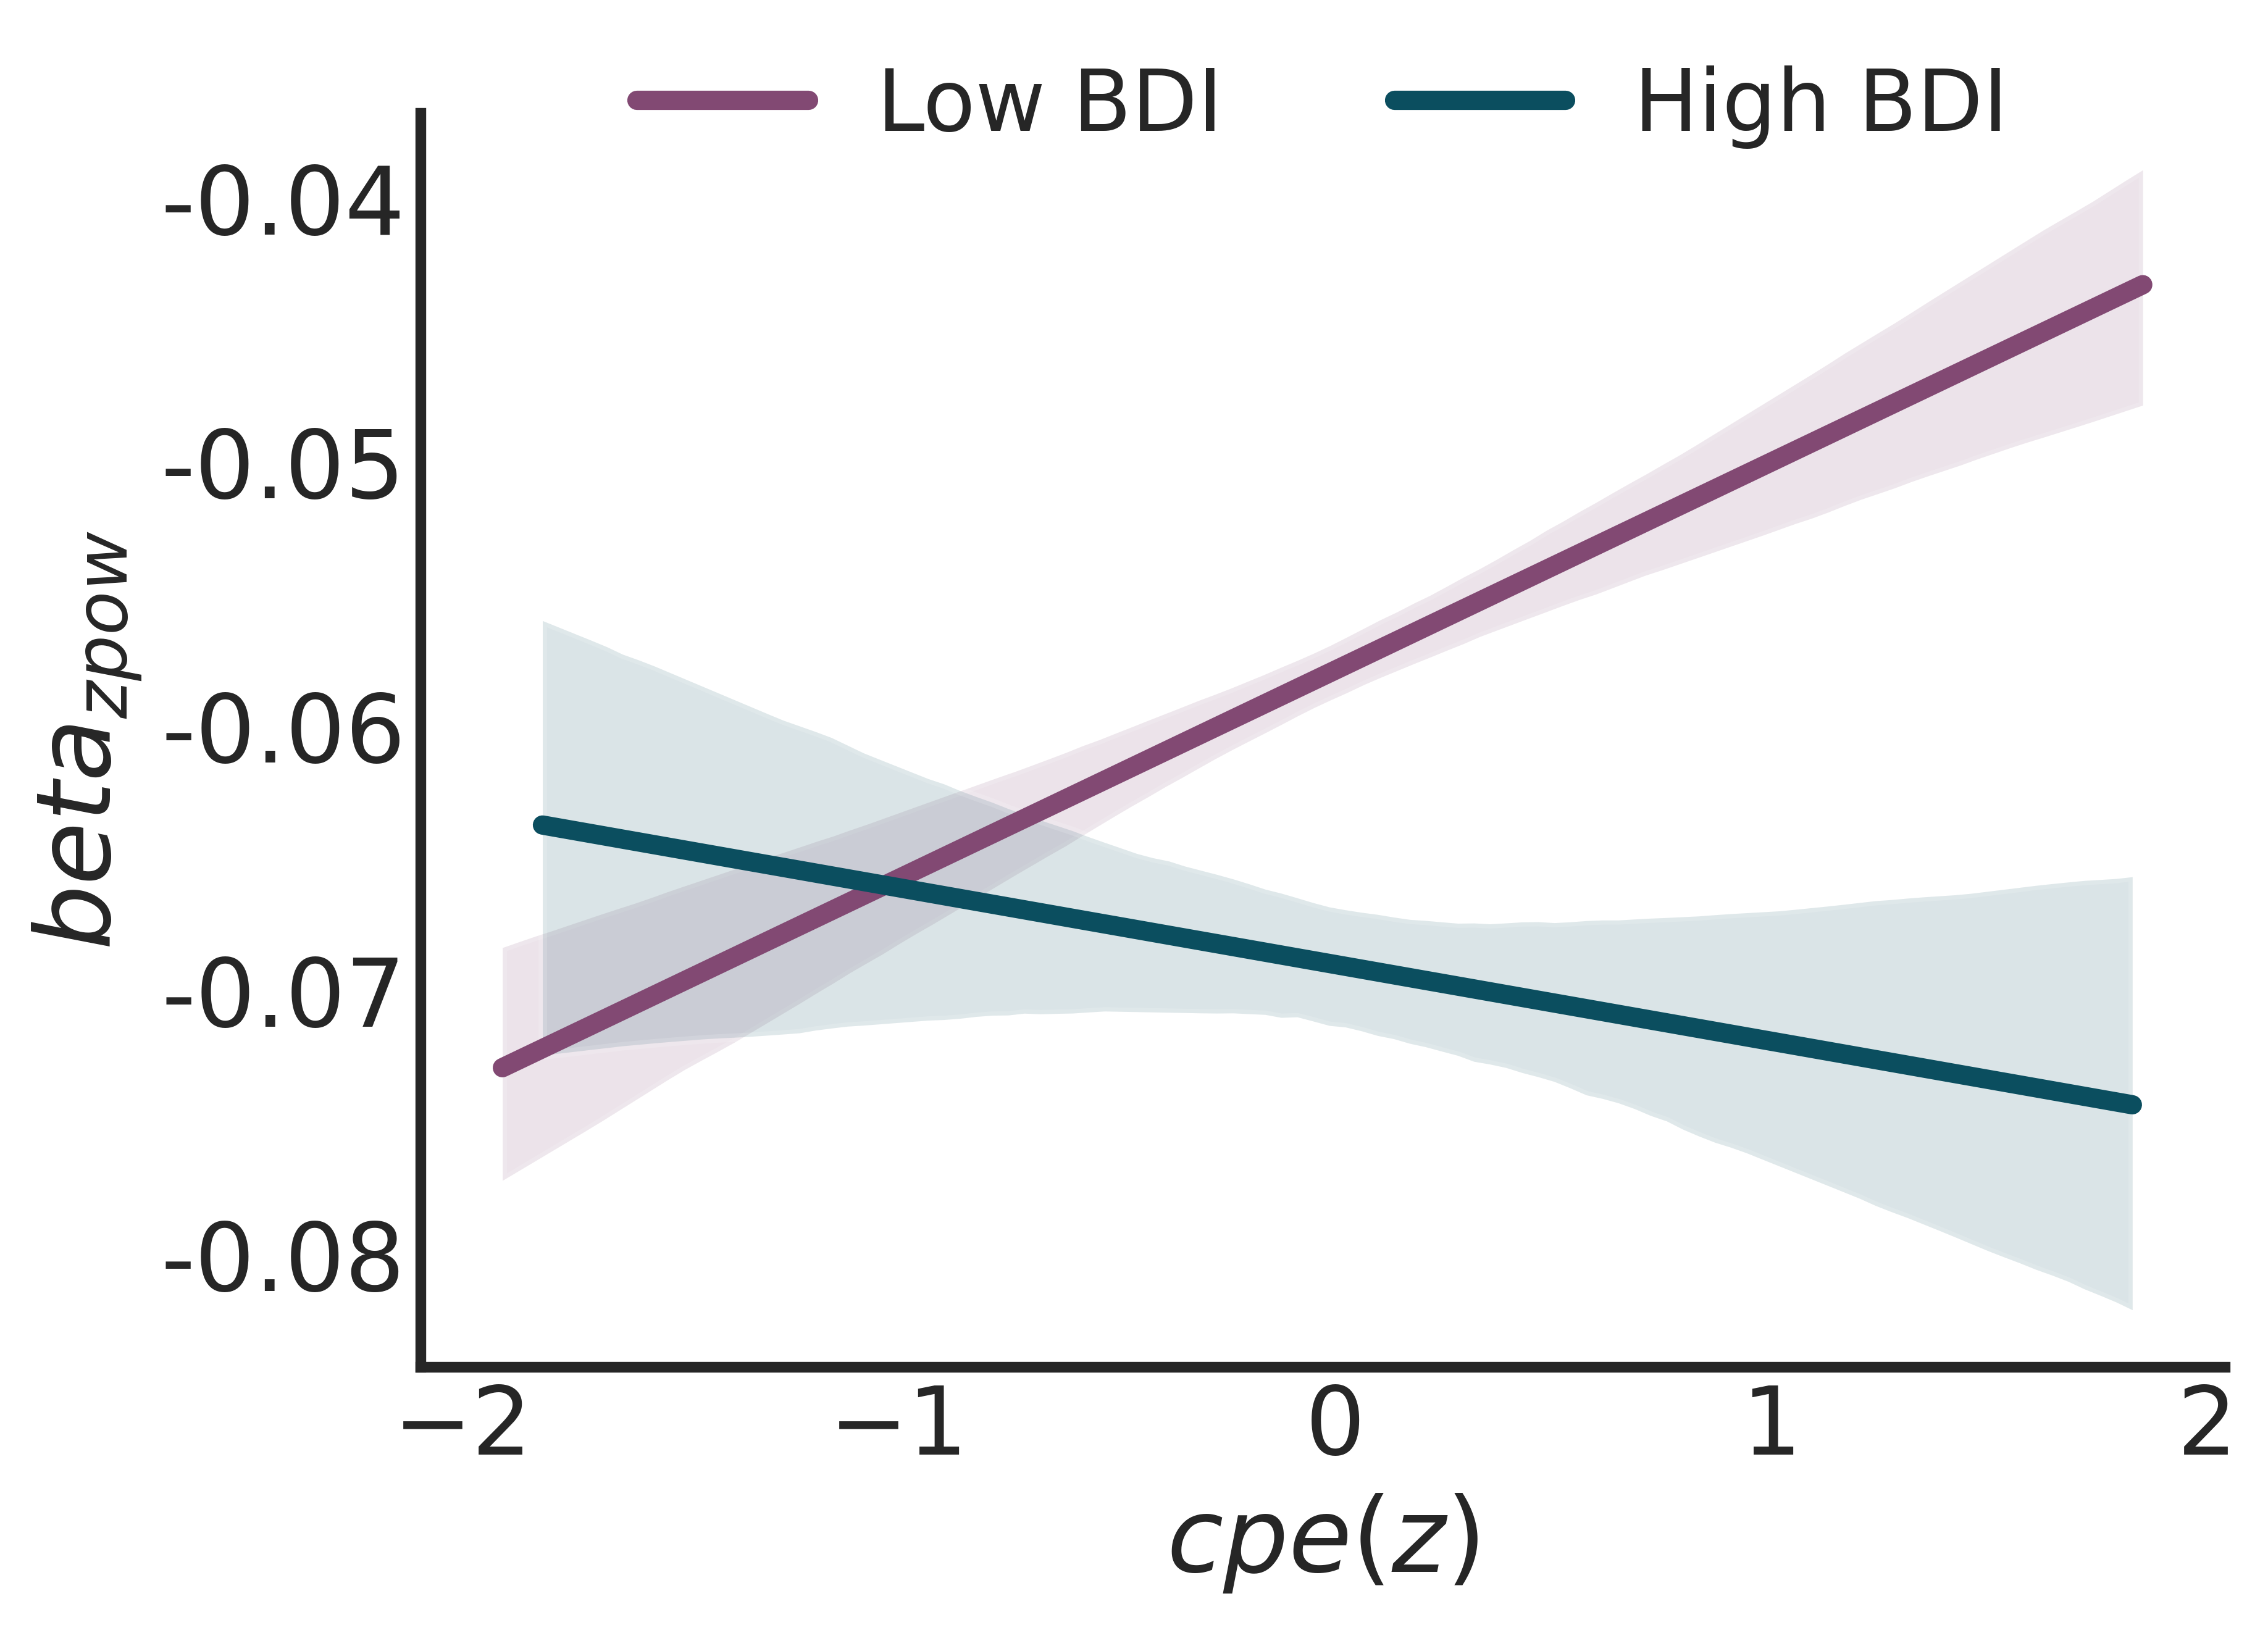

In [40]:
## X plot attempt 

sns.set_theme(style='ticks') 
sns.set_context("poster")


fig,ax = plt.subplots(figsize=(8,6),dpi=500)


# sns.regplot(data=beta_reg_df[beta_reg_df.Depressed=='Low BDI'],x='decisionCPE',y='band_pow',scatter=True,
#            ci=95,color = '#824973',label='Low BDI',x_jitter = 0.15,scatter_kws={'s':5})
# sns.regplot(data=beta_reg_df[beta_reg_df.Depressed=='High BDI'],x='decisionCPE',y='band_pow',scatter=True,
#            ci=95,color='#0b4e5f',label='High BDI',x_jitter = 0.15,scatter_kws={'s':5})

sns.regplot(data=beta_reg_df[beta_reg_df.Depressed=='Low BDI'],x='decisionCPE',y='band_pow',scatter=False,
           ci=95,color = '#824973',label='Low BDI')
sns.regplot(data=beta_reg_df[beta_reg_df.Depressed=='High BDI'],x='decisionCPE',y='band_pow',scatter=False,
           ci=95,color='#0b4e5f',label='High BDI')

plt.legend(fontsize=10)
# borderaxespad=0,frameon=False,framealpha=0,
sns.move_legend(ax,"upper center", bbox_to_anchor=(0.5, 1.1), frameon=False,framealpha=0,
                fontsize='small',shadow=None,
                columnspacing=2,ncol=2)


plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 
plt.tight_layout()
plt.ylabel(r'$beta_{{{zpow}}}$')
plt.xlabel(r'$cpe(z)$')
sns.despine()
plt.tick_params(length=0)


# plt.savefig(f'{fig_save_dir}/all_lmplot_cpe_bpow_bdi_{date}.pdf', format='pdf', metadata=None,
# bbox_inches='tight', pad_inches=0.1,dpi=500,
# facecolor='auto', edgecolor='auto',
# backend=None)

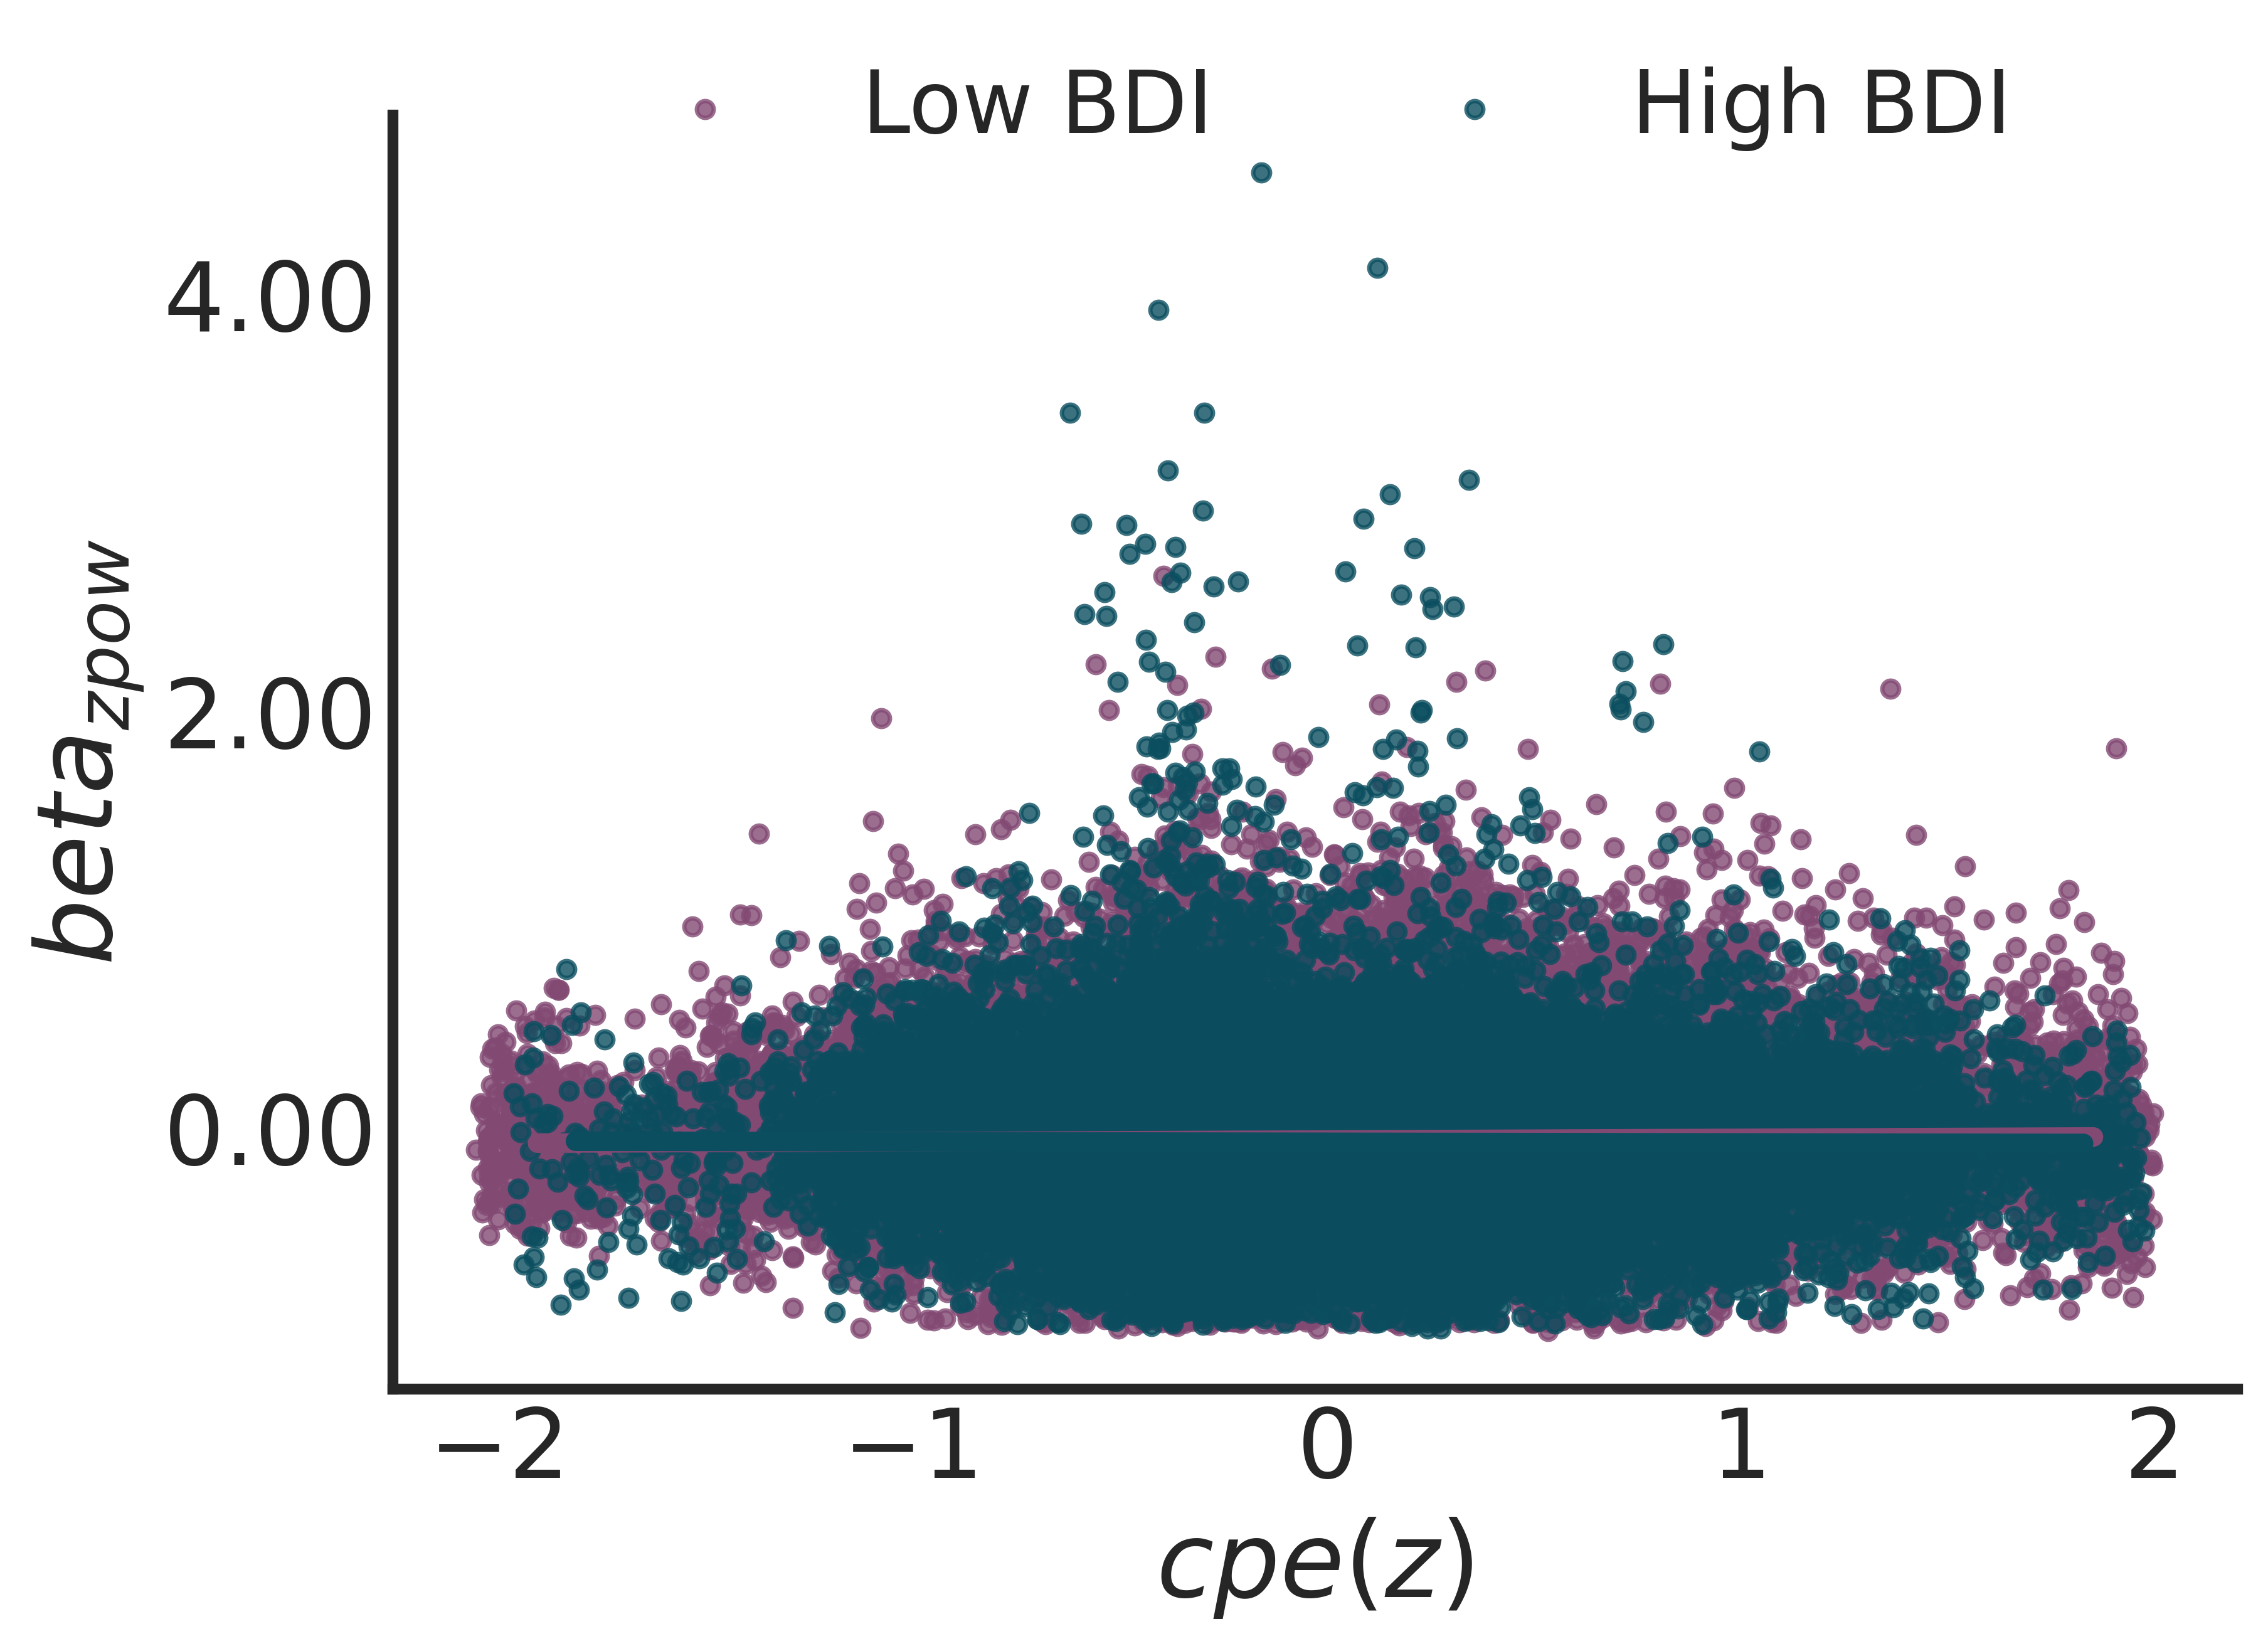

In [41]:
## X plot attempt 

sns.set_theme(style='ticks') 
sns.set_context("poster")


fig,ax = plt.subplots(figsize=(8,6),dpi=500)


sns.regplot(data=beta_reg_df[beta_reg_df.Depressed=='Low BDI'],x='decisionCPE',y='band_pow',scatter=True,
           ci=95,color = '#824973',label='Low BDI',x_jitter = 0.15,scatter_kws={'s':15})
sns.regplot(data=beta_reg_df[beta_reg_df.Depressed=='High BDI'],x='decisionCPE',y='band_pow',scatter=True,
           ci=95,color='#0b4e5f',label='High BDI',x_jitter = 0.15,scatter_kws={'s':15})

plt.legend(fontsize=10)
# borderaxespad=0,frameon=False,framealpha=0,
sns.move_legend(ax,"upper center", bbox_to_anchor=(0.5, 1.1), frameon=False,framealpha=0,
                fontsize='small',shadow=None,
                columnspacing=2,ncol=2)


plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 
plt.tight_layout()
plt.ylabel(r'$beta_{{{zpow}}}$')
plt.xlabel(r'$cpe(z)$')
sns.despine()
plt.tick_params(length=0)


# plt.savefig(f'{fig_save_dir}/all_lmplot_cpe_bpow_bdi_{date}.pdf', format='pdf', metadata=None,
# bbox_inches='tight', pad_inches=0.1,dpi=500,
# facecolor='auto', edgecolor='auto',
# backend=None)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


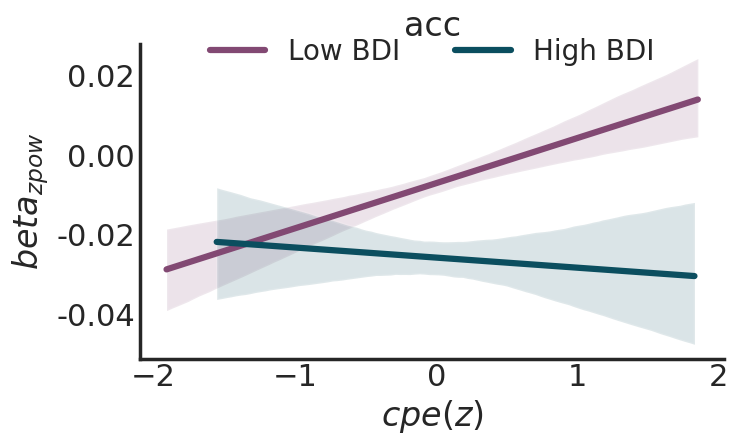

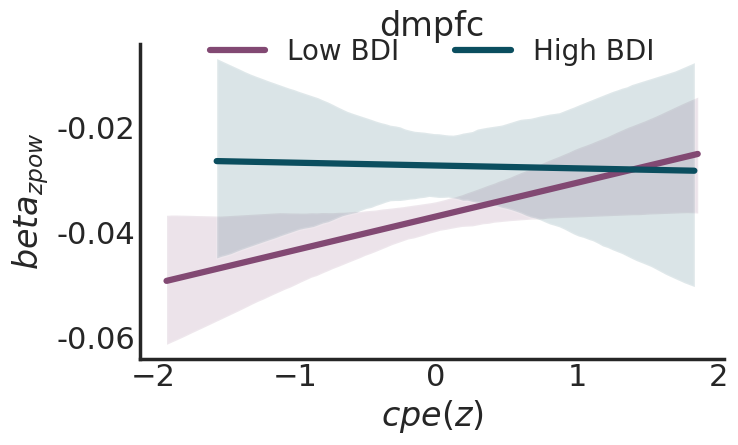

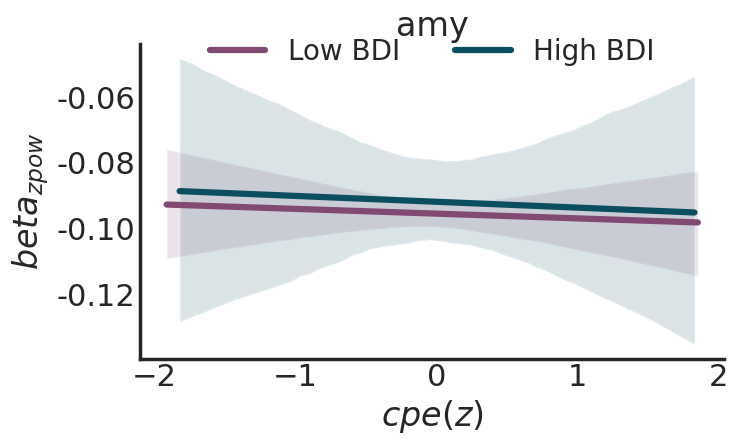

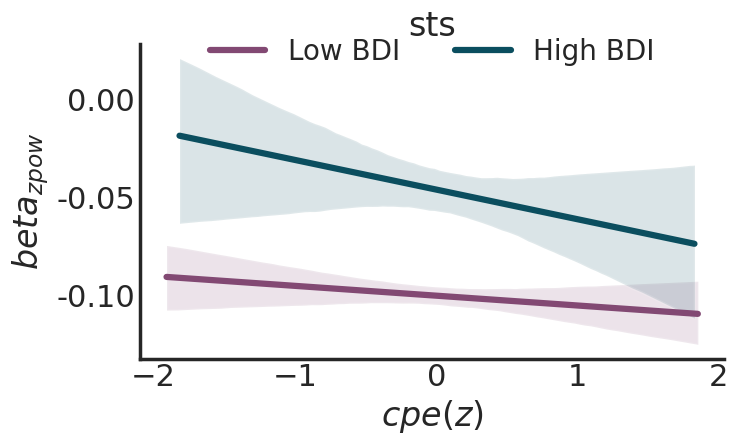

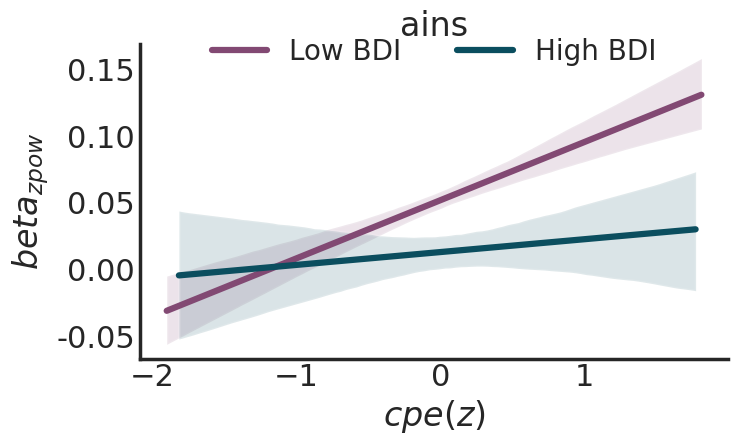

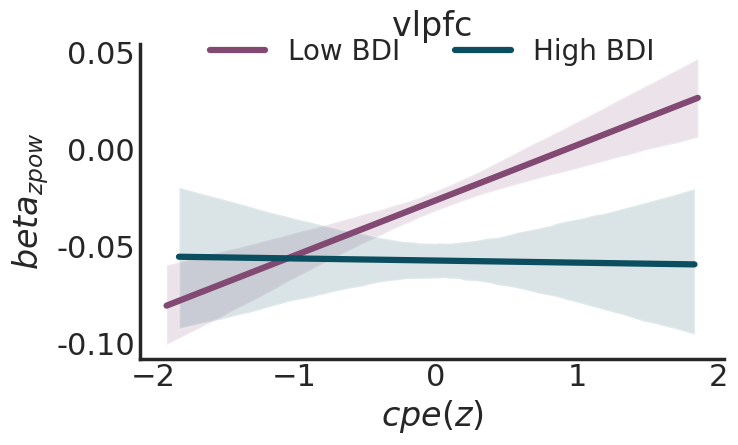

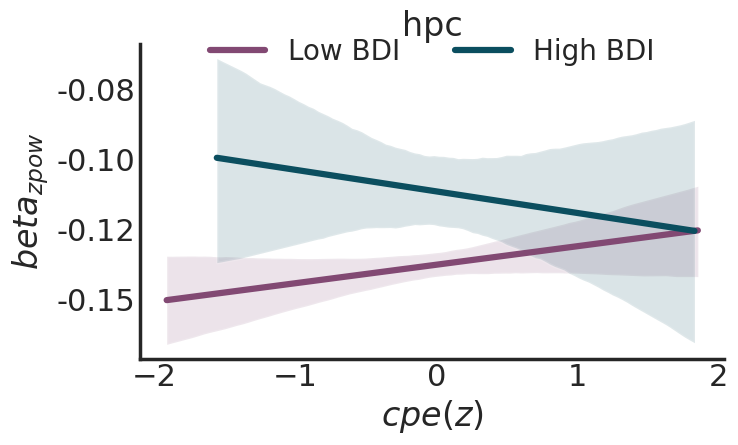

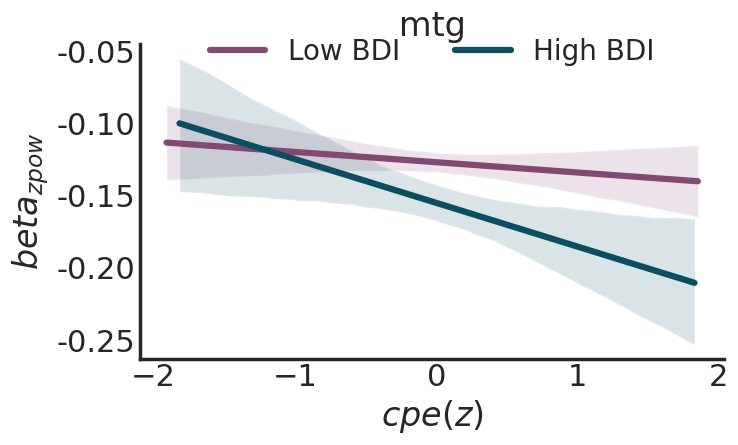

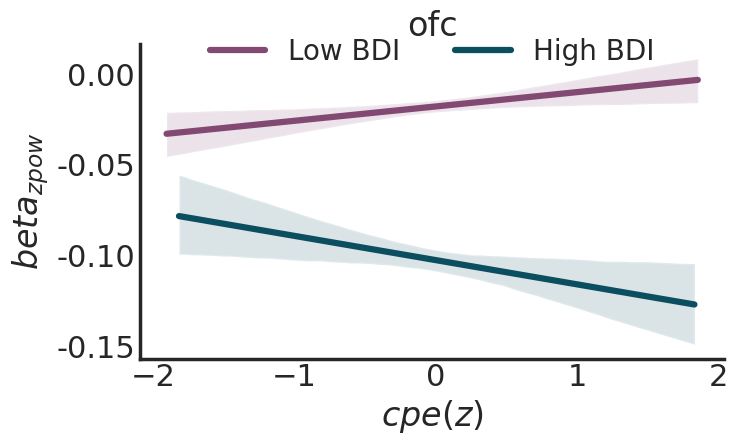

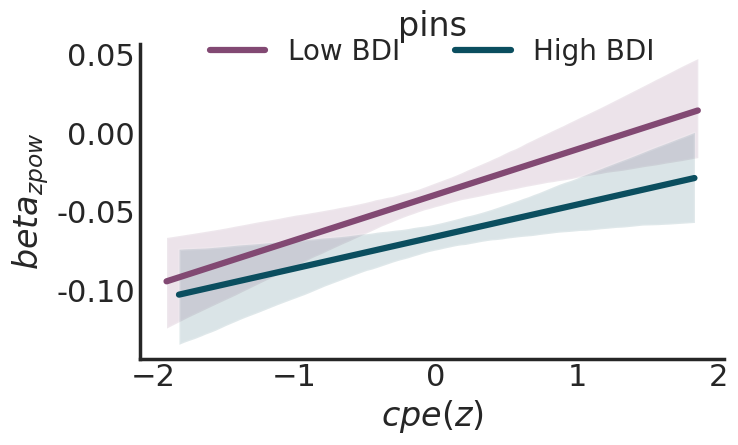

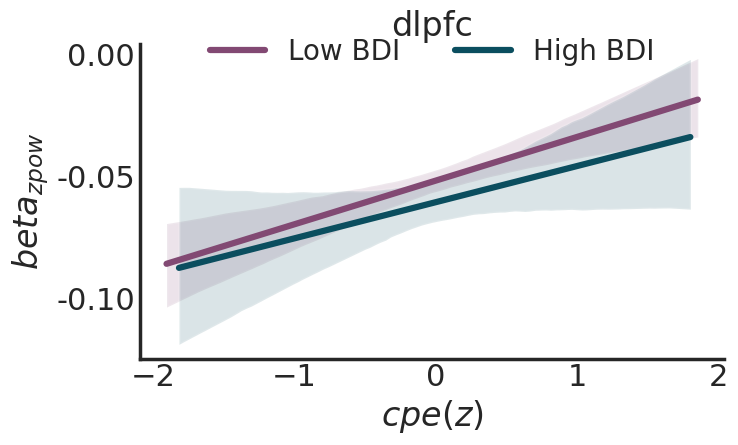

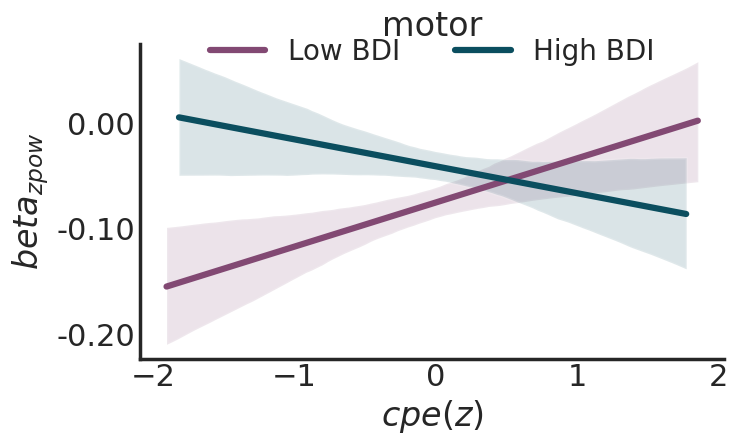

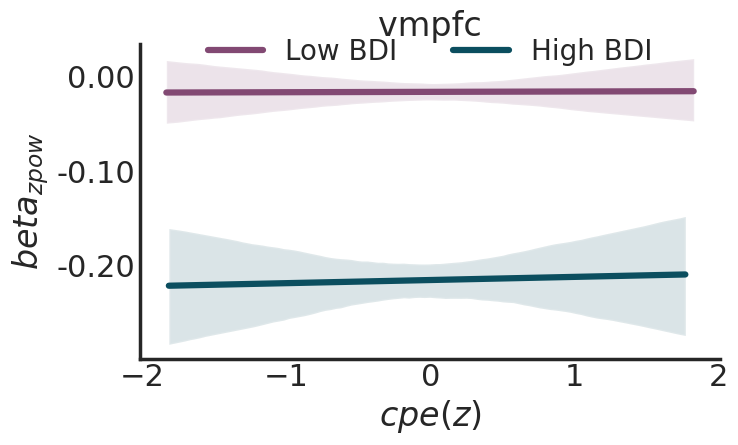

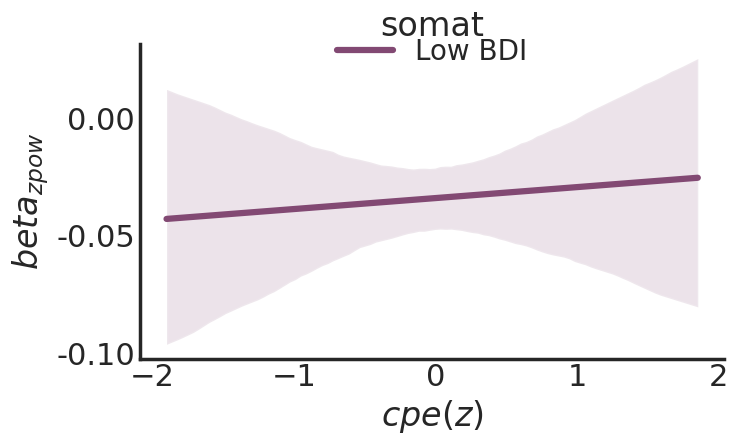

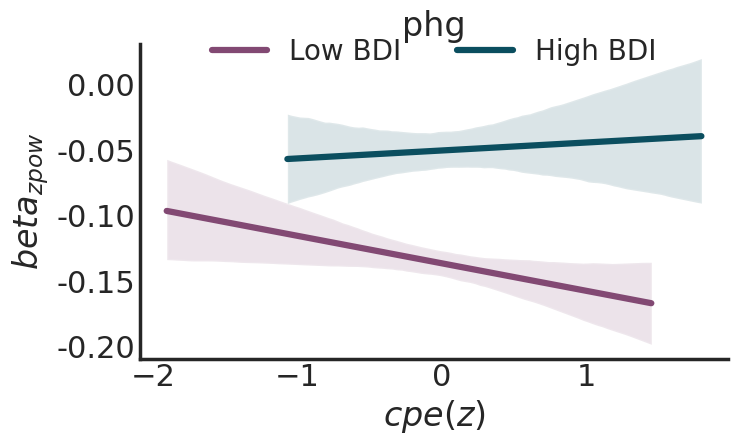

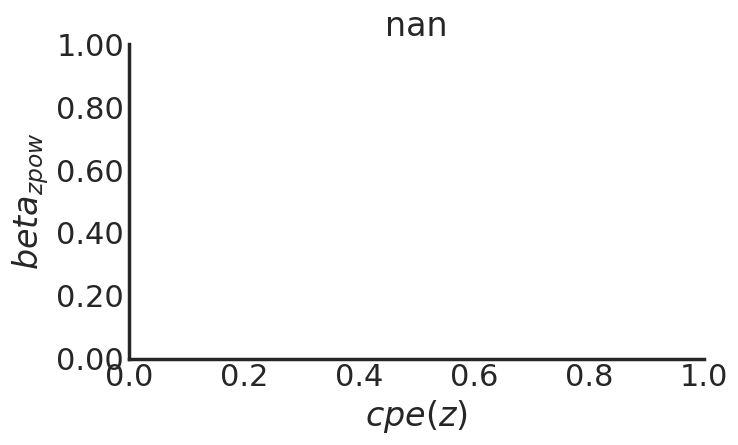

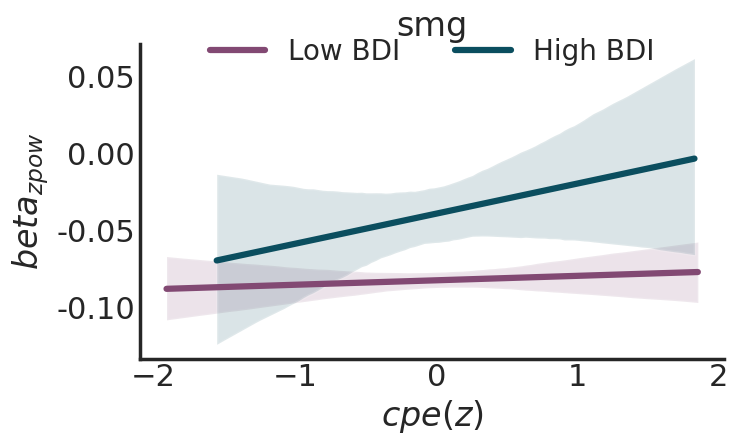

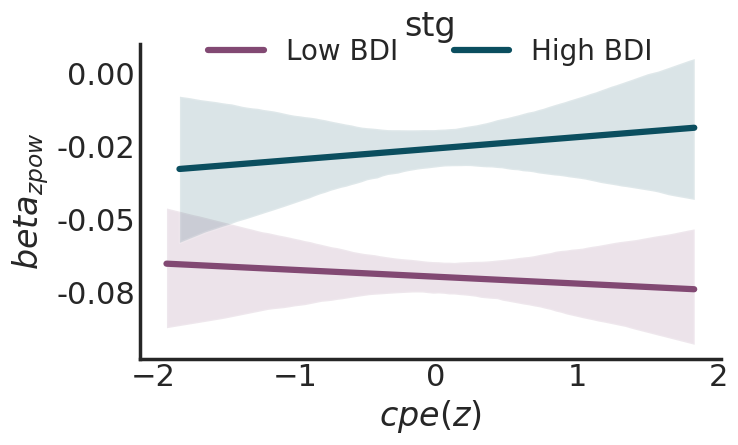

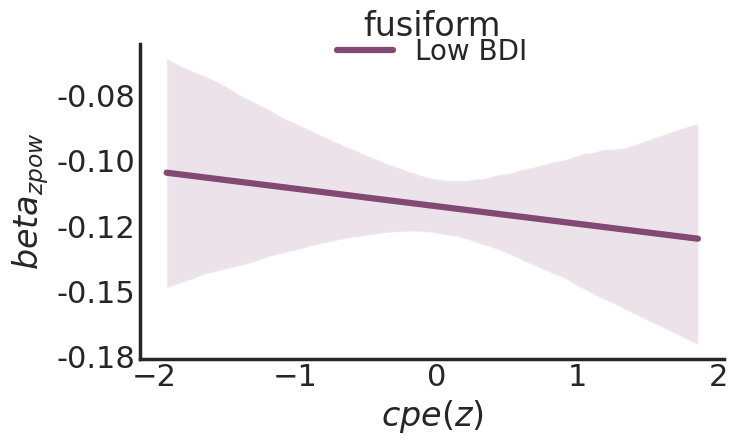

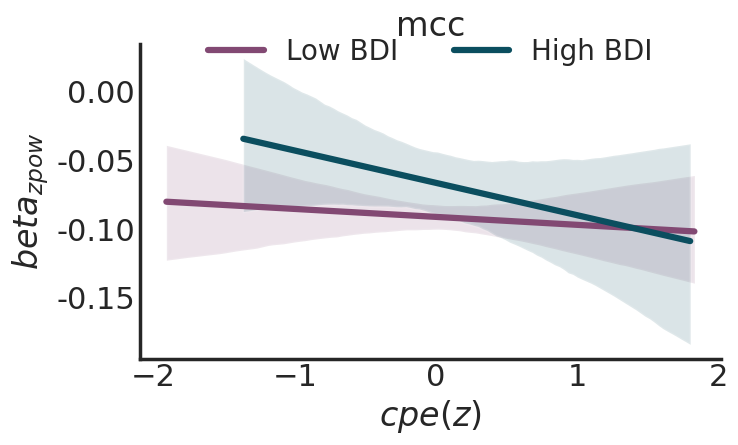

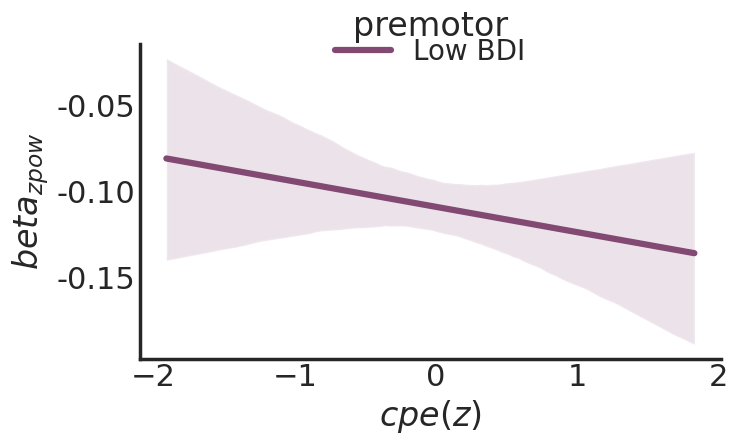

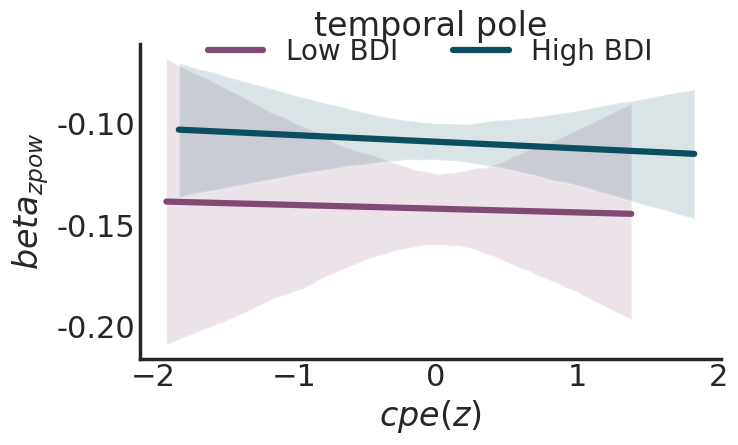

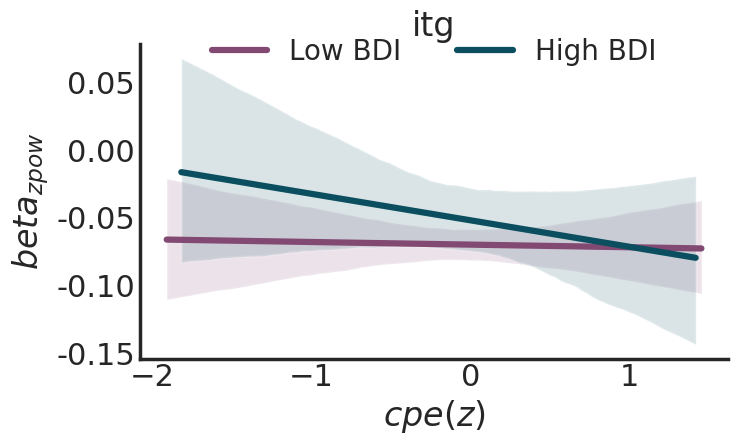

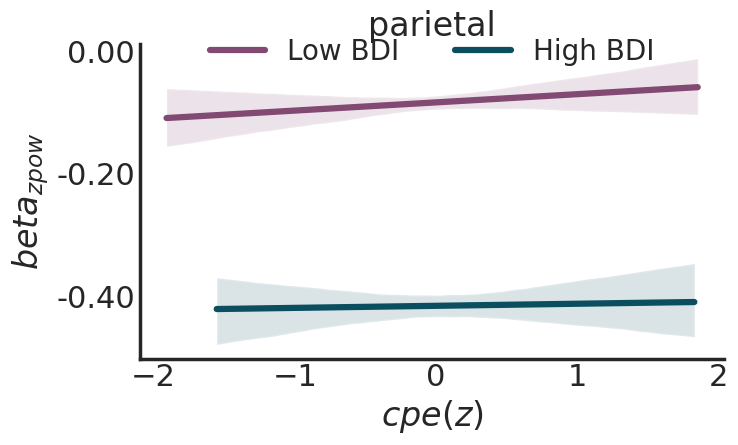

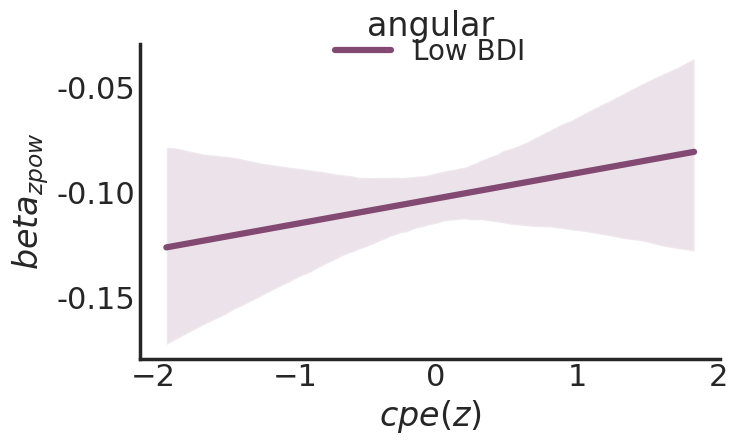

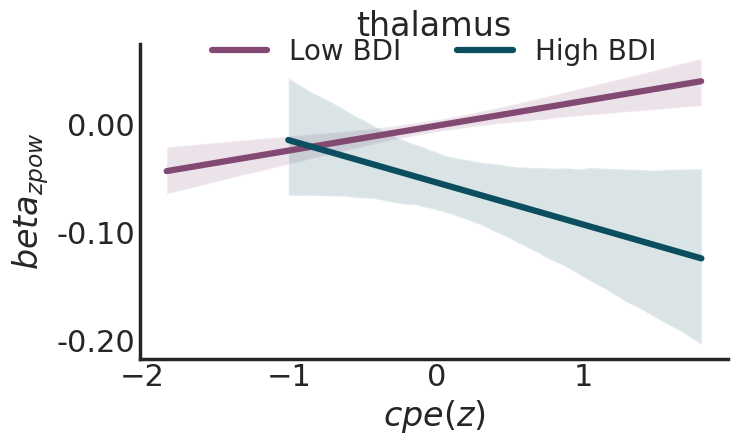

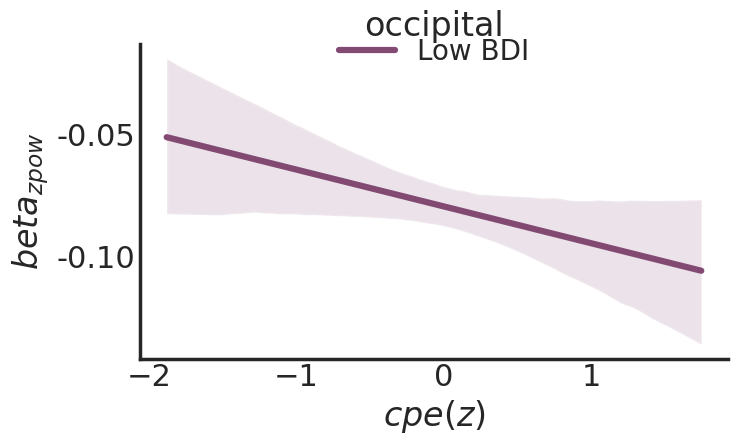

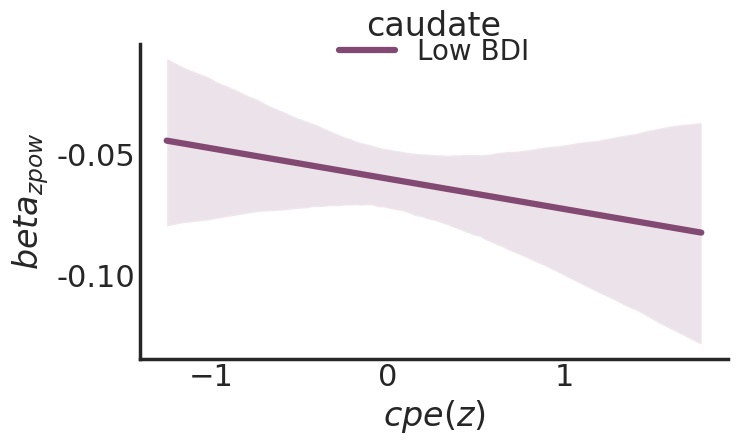

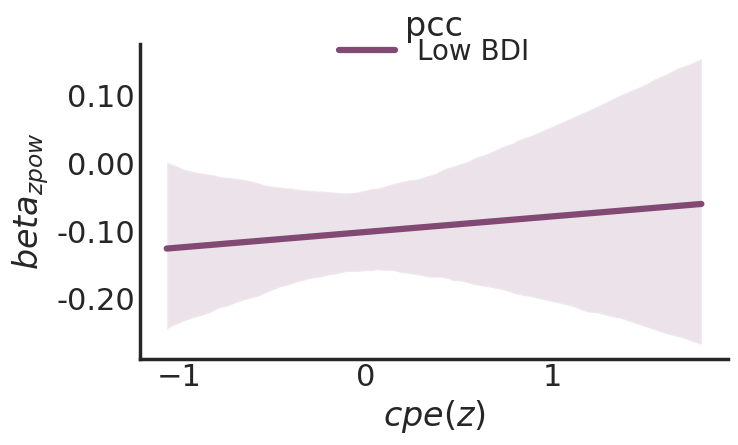

In [42]:
for roi in beta_reg_df.roi.unique().tolist():
    roi_reg_plot = beta_reg_df[beta_reg_df.roi== roi]
    fig,ax = plt.subplots(figsize=(8,5))

    sns.regplot(data=roi_reg_plot[roi_reg_plot.Depressed=='Low BDI'],x='decisionCPE',y='band_pow',scatter=False,
               ci=95,color = '#824973',label='Low BDI')#,scatter_kws={'s':2})
    sns.regplot(data=roi_reg_plot[roi_reg_plot.Depressed=='High BDI'],x='decisionCPE',y='band_pow',scatter=False,
               ci=95,color='#0b4e5f',label='High BDI')#,scatter_kws={'s':2})

    plt.legend(fontsize=10)
    # borderaxespad=0,frameon=False,framealpha=0,
    sns.move_legend(ax,"upper center", bbox_to_anchor=(0.5, 1.1), frameon=False,framealpha=0,
                    fontsize='small',shadow=None,
                    columnspacing=2,ncol=2)


    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 
    plt.tight_layout()
    plt.ylabel(r'$beta_{{{zpow}}}$')
    plt.xlabel(r'$cpe(z)$')
    plt.title(f'{roi}')
    sns.despine()
    plt.tick_params(length=0)
    
    

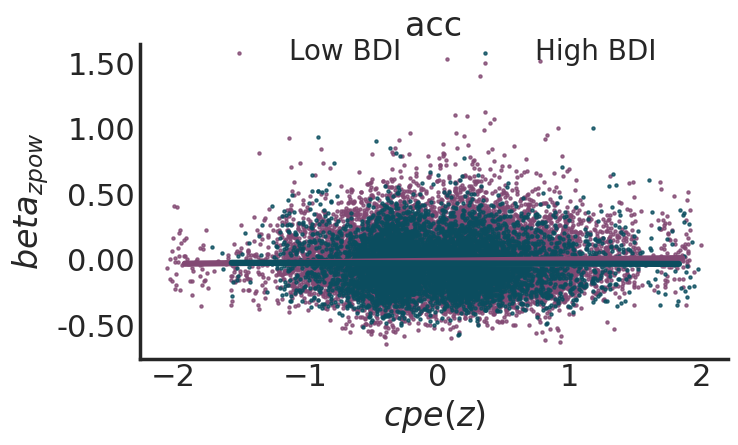

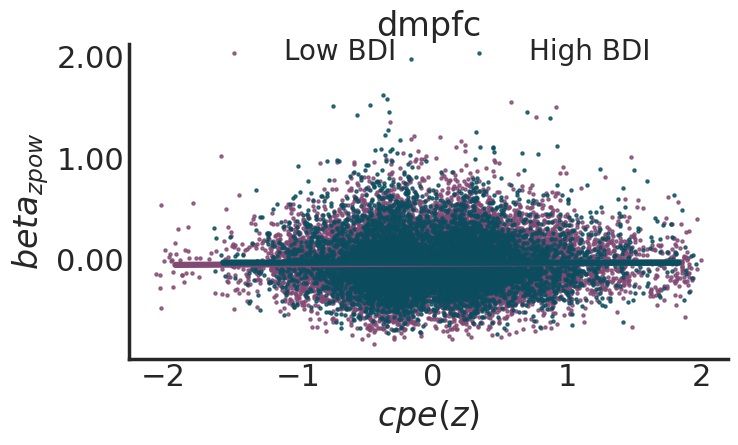

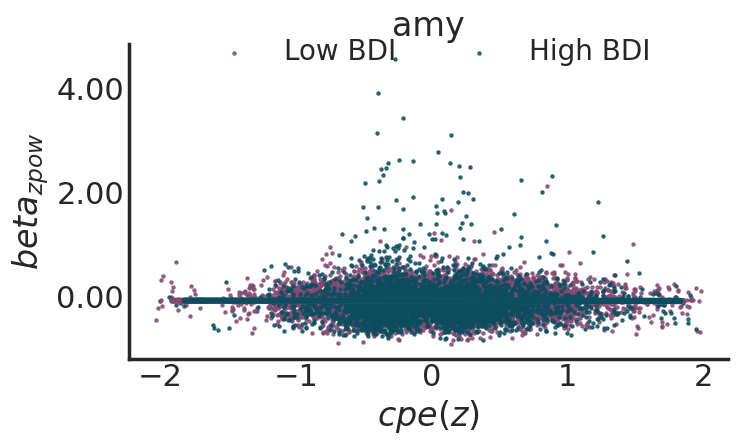

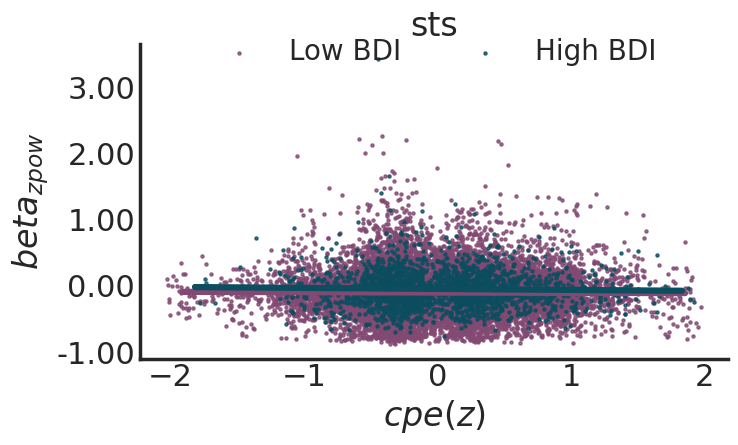

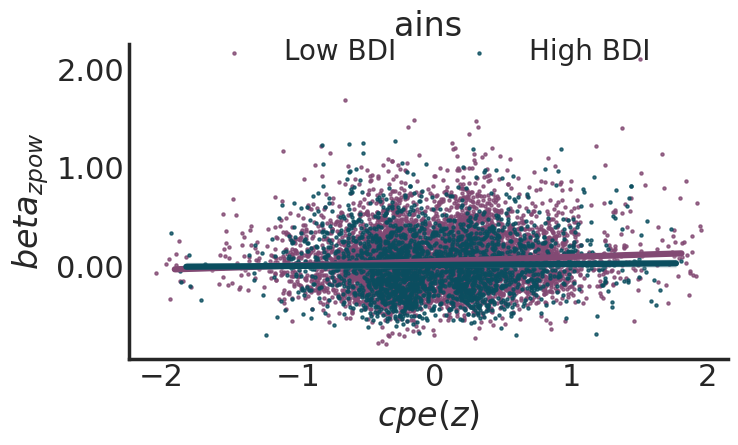

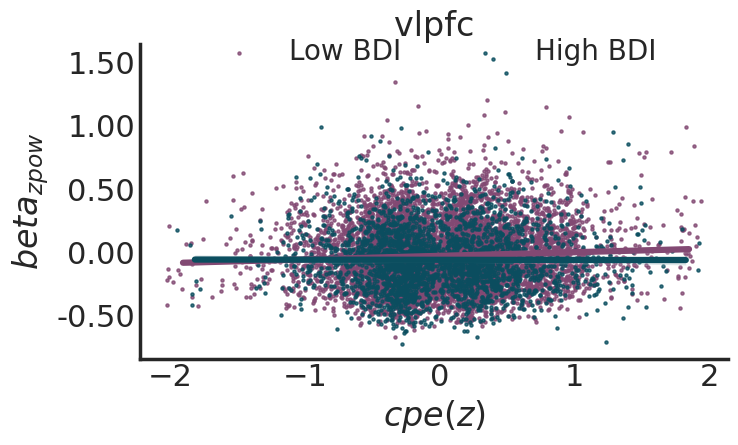

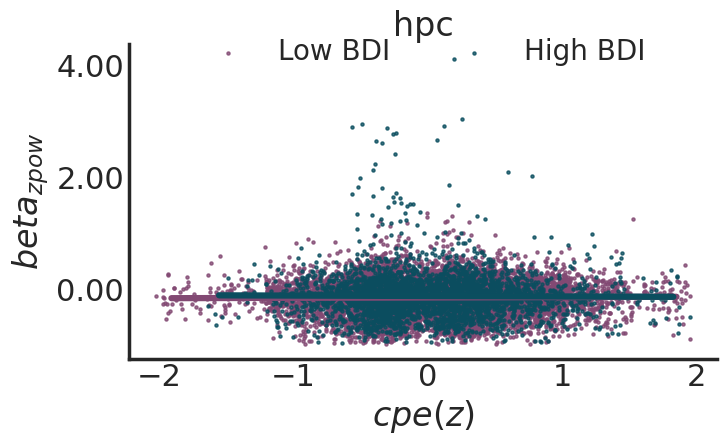

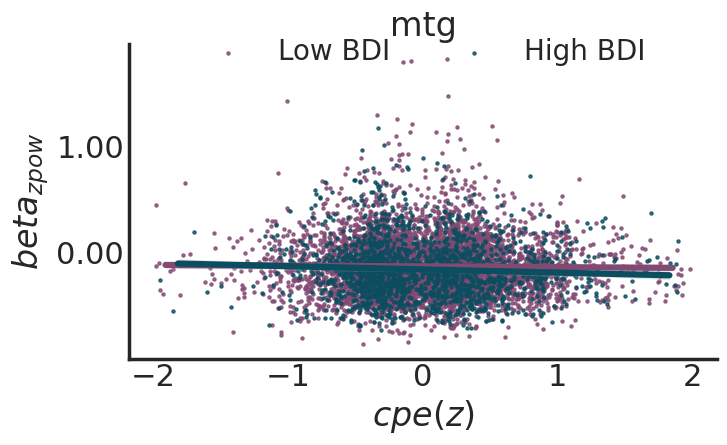

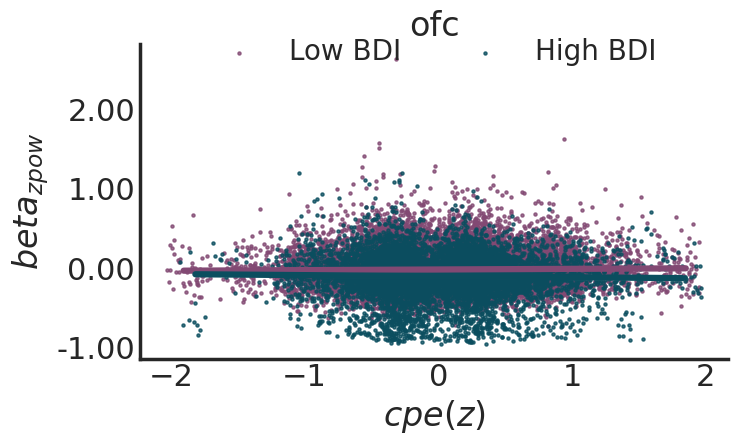

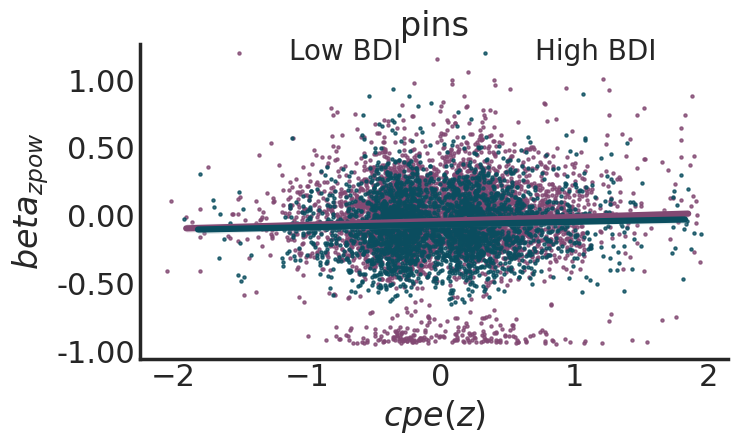

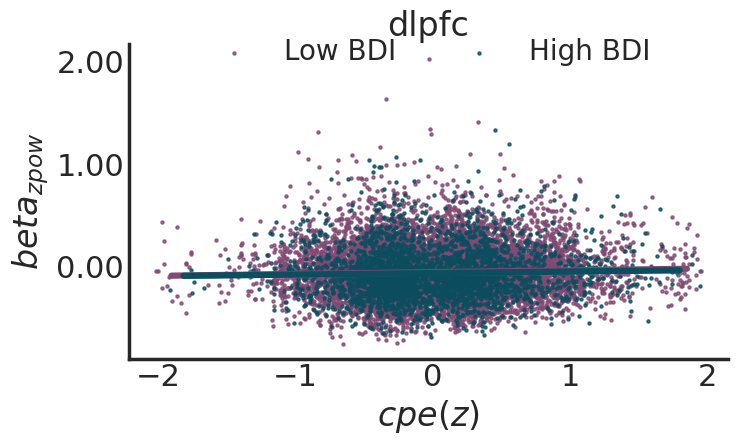

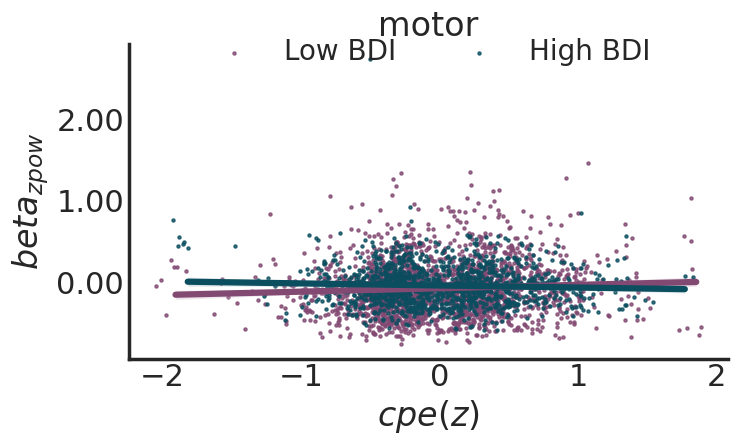

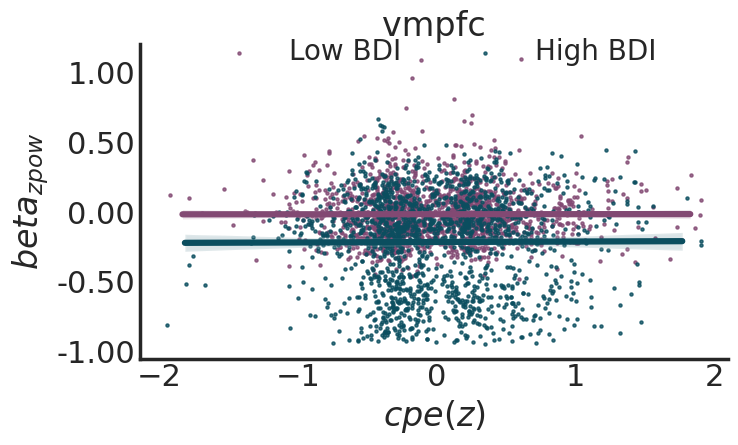

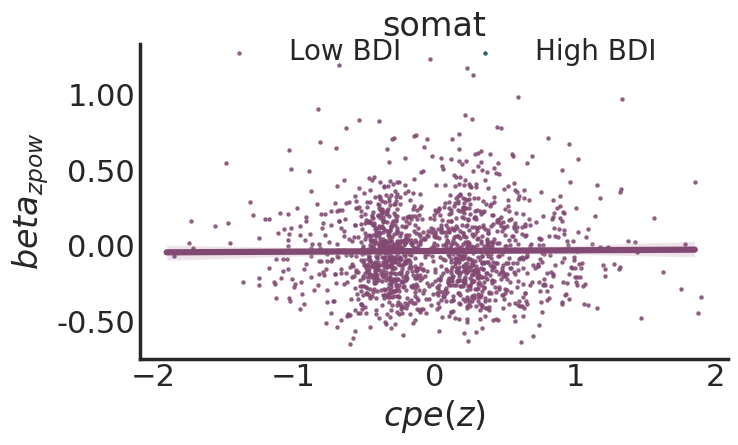

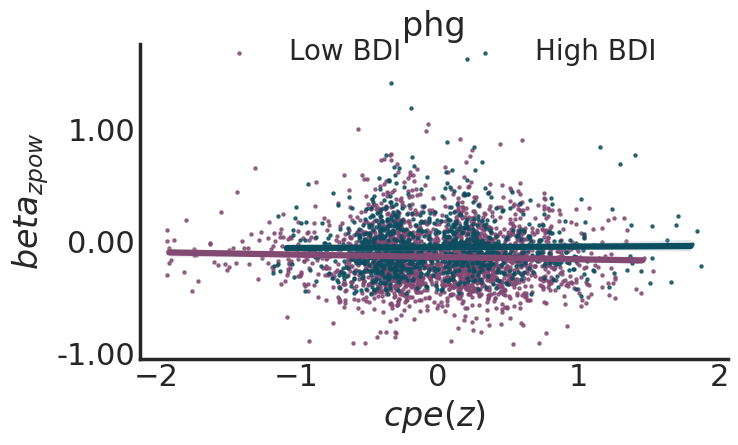

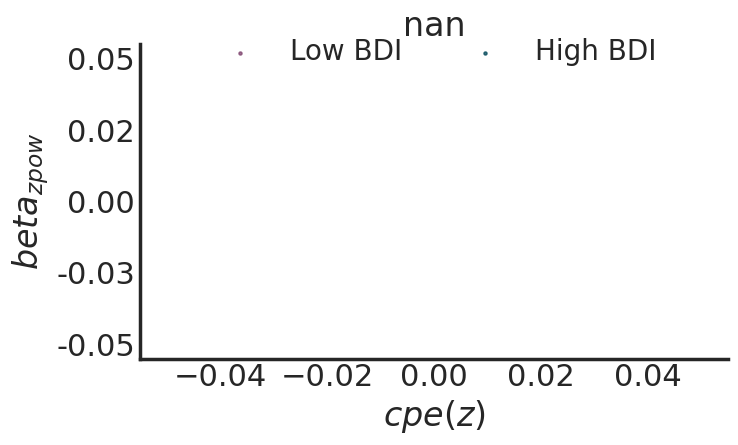

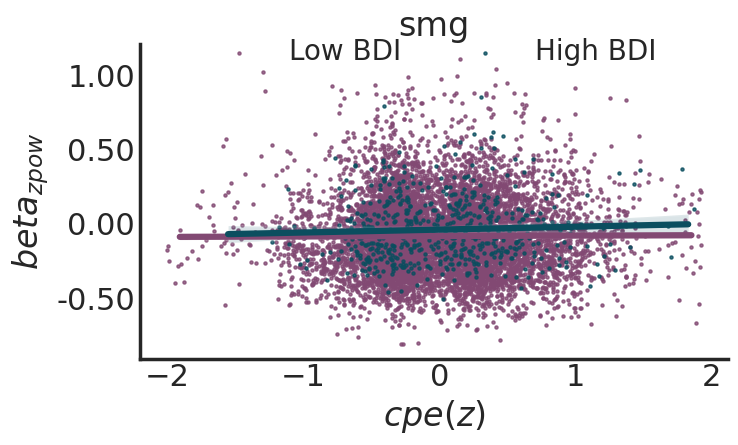

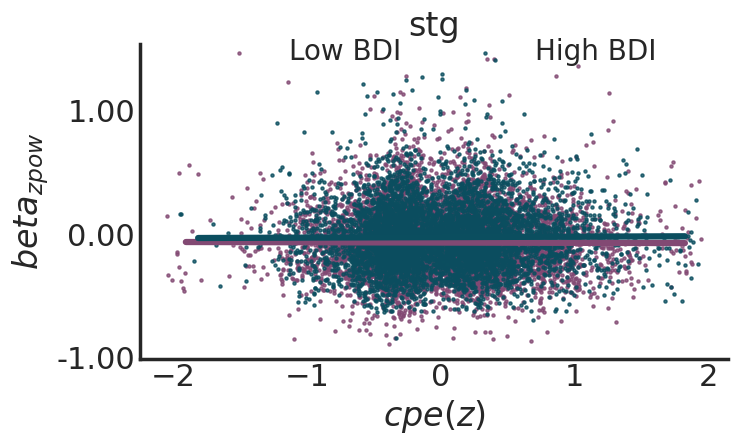

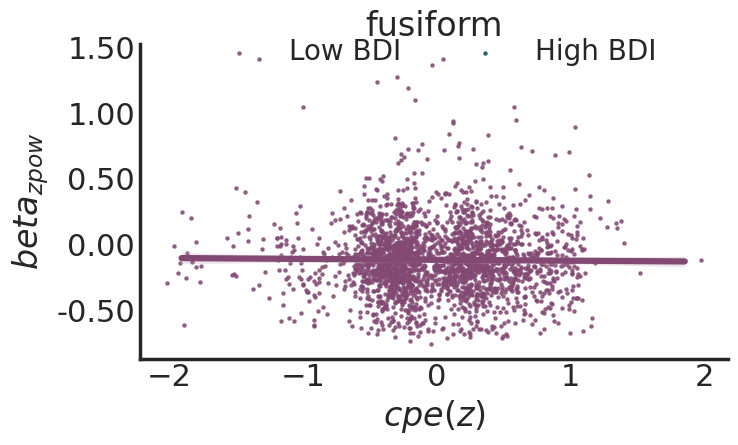

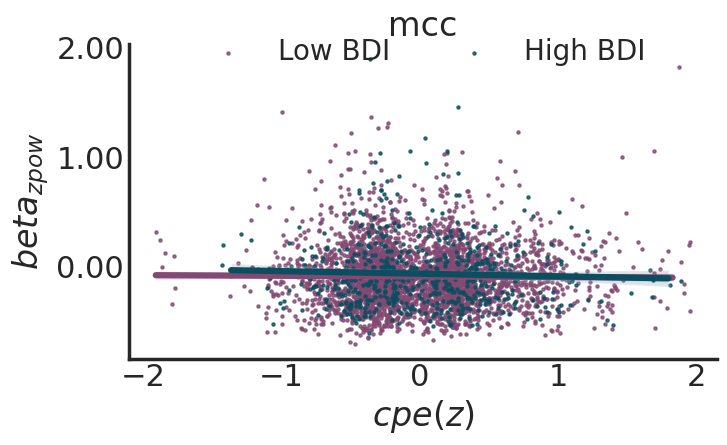

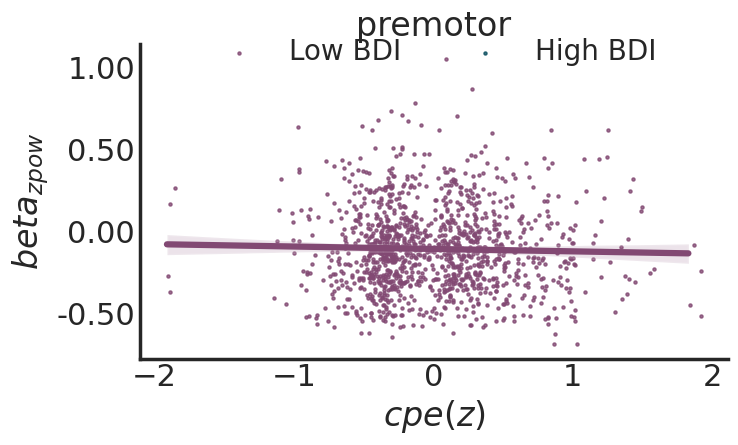

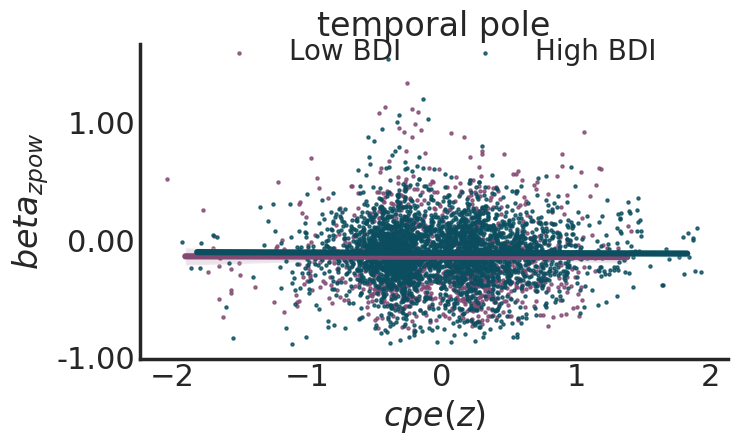

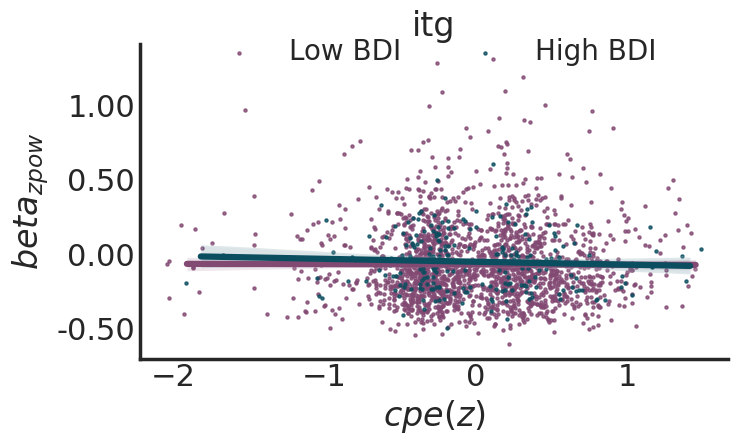

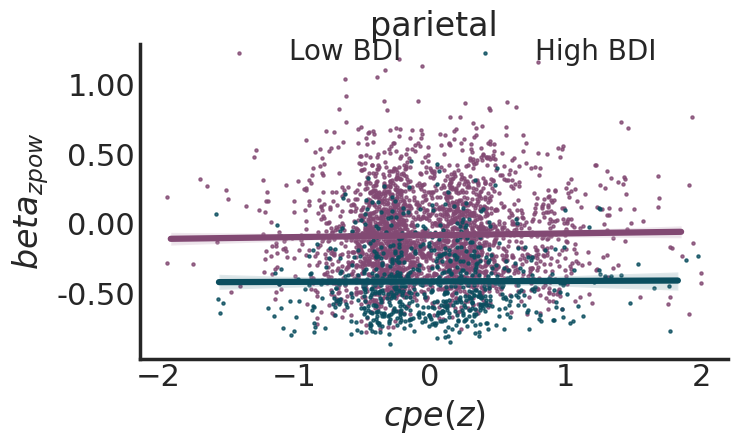

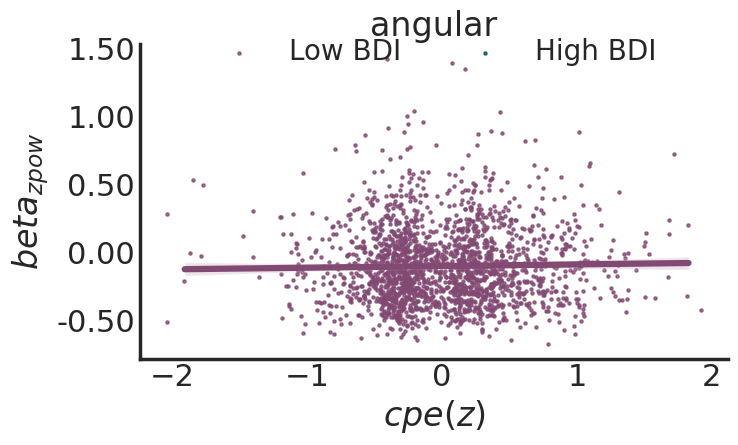

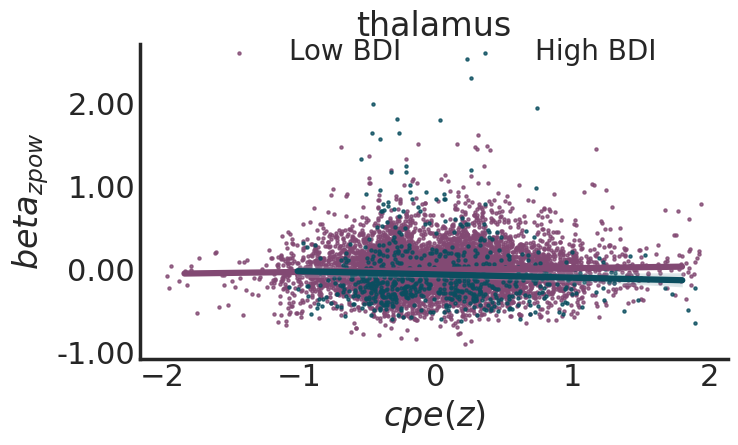

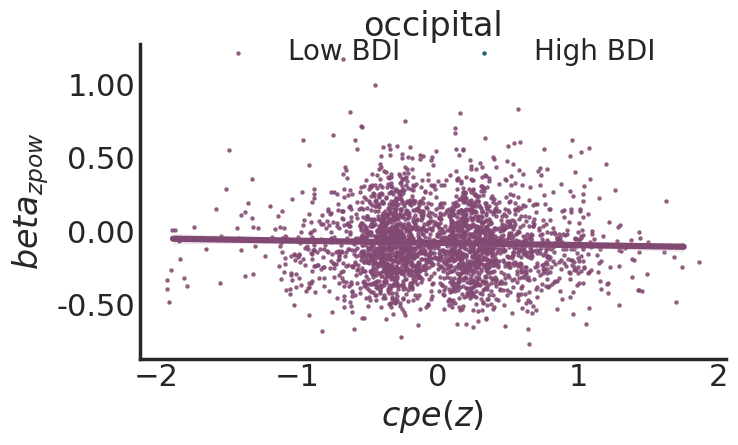

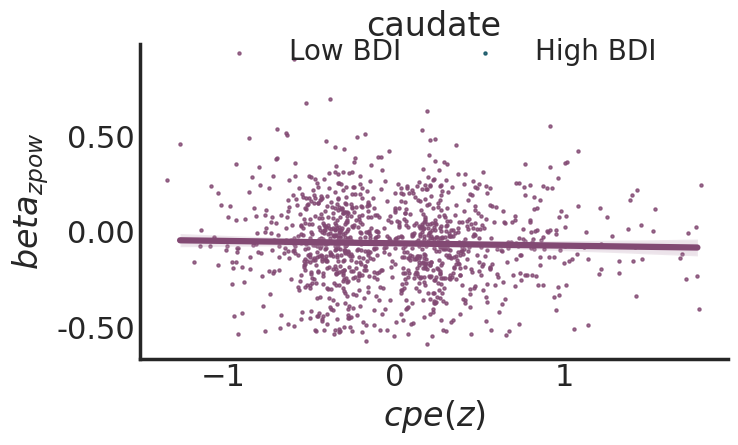

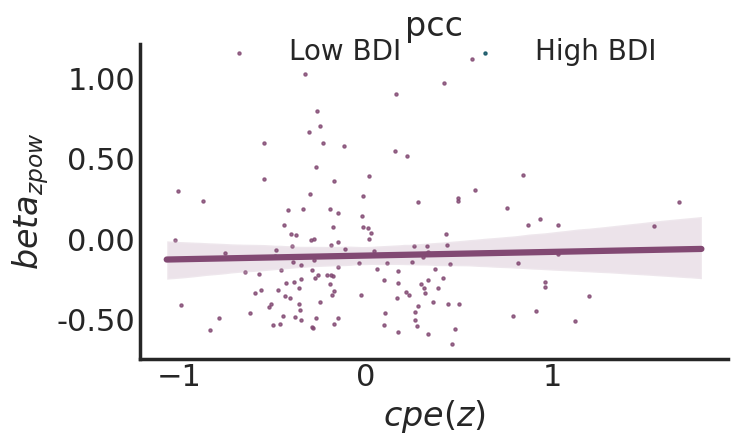

In [43]:
for roi in beta_reg_df.roi.unique().tolist():
    roi_reg_plot = beta_reg_df[beta_reg_df.roi== roi]
    fig,ax = plt.subplots(figsize=(8,5))

    sns.regplot(data=roi_reg_plot[roi_reg_plot.Depressed=='Low BDI'],x='decisionCPE',y='band_pow',scatter=True,
               ci=95,color = '#824973',label='Low BDI',x_jitter = 0.15,scatter_kws={'s':5})
    sns.regplot(data=roi_reg_plot[roi_reg_plot.Depressed=='High BDI'],x='decisionCPE',y='band_pow',scatter=True,
               ci=95,color='#0b4e5f',label='High BDI',x_jitter = 0.15,scatter_kws={'s':5})

    plt.legend(fontsize=10)
    # borderaxespad=0,frameon=False,framealpha=0,
    sns.move_legend(ax,"upper center", bbox_to_anchor=(0.5, 1.1), frameon=False,framealpha=0,
                    fontsize='small',shadow=None,
                    columnspacing=2,ncol=2)


    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 
    plt.tight_layout()
    plt.ylabel(r'$beta_{{{zpow}}}$')
    plt.xlabel(r'$cpe(z)$')
    plt.title(f'{roi}')
    sns.despine()
    plt.tick_params(length=0)
    
    

In [36]:
# for roi in beta_reg_df.roi.unique().tolist():
#     roi_reg_plot = beta_reg_df[beta_reg_df.roi== roi]
#     fig,ax = plt.subplots(figsize=(8,5),dpi=500)

#     sns.regplot(data=roi_reg_plot[roi_reg_plot.Depressed=='Low BDI'],x='decisionCPE',y='band_pow',scatter=True,
#                ci=95,color = '#824973',label='Low BDI',x_jitter = 0.15)#,scatter_kws={'s':2})
#     sns.regplot(data=roi_reg_plot[roi_reg_plot.Depressed=='High BDI'],x='decisionCPE',y='band_pow',scatter=True,
#                ci=95,color='#0b4e5f',label='High BDI',x_jitter = 0.15)#,scatter_kws={'s':2})

#     plt.legend(fontsize=10)
#     # borderaxespad=0,frameon=False,framealpha=0,
#     sns.move_legend(ax,"upper center", bbox_to_anchor=(0.5, 1.1), frameon=False,framealpha=0,
#                     fontsize='small',shadow=None,
#                     columnspacing=2,ncol=2)


#     plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 

#     plt.ylabel(r'$beta_{{{zpow}}}$')
#     plt.xlabel(r'$cpe(z)$')
#     plt.title(f'{roi}')
#     sns.despine()
#     plt.tick_params(length=0)
    
    

### test plots

In [26]:
# ains_time_res = pd.read_csv('/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/results/ains_beta_time_resolved.csv')

# time_range = [0.0,2.0]
# ains_2sec_crop = ains_time_res[(ains_time_res.time>=time_range[1])&(ains_time_res.time<=time_range[1])]
# # ains_2sec_crop = 
# ains_2sec_crop['unique_reref_ch'] = ains_2sec_crop[['subj_id', 'reref_ch_names']].agg('_'.join, axis=1)
# ains_2sec_crop


In [19]:
plot_ains = ains_2sec_crop.groupby(['epoch_num']).agg('mean').reset_index()


In [25]:
plot_ains.columns

Index(['epoch_num', 'Unnamed: 0', 'level_0', 'time', 'freq', 'band_pow',
       'index', 'Round', 'RT', 'CpeOnset', 'SafeBet', 'LowBet', 'HighBet',
       'GambleEV', 'Profit', 'TotalProfit', 'CR', 'choiceEV', 'RPE',
       'decisionCPE', 'decisionRegret', 'decisionRelief', 'decisionCF', 'cpe',
       'cpe_split', 'TrialEV', 'bdi', 'Depressed'],
      dtype='object')

In [21]:
plot_ains['Depressed'] = ['High BDI' if bdi >=20 else 'Low BDI' for bdi in plot_ains.bdi.tolist()]

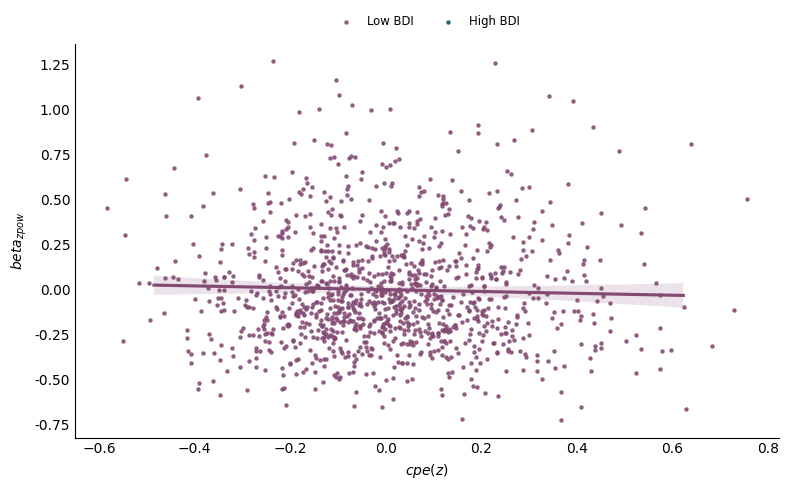

In [22]:
## X plot attempt 

fig,ax = plt.subplots(figsize=(8,5))

sns.regplot(data=plot_ains[plot_ains.Depressed=='Low BDI'],x='decisionCPE',y='band_pow',scatter=True,
           ci=95,color = '#824973',label='Low BDI',x_jitter = 0.15,scatter_kws={'s':5})
sns.regplot(data=plot_ains[plot_ains.Depressed=='High BDI'],x='decisionCPE',y='band_pow',scatter=True,
           ci=95,color='#0b4e5f',label='High BDI',x_jitter = 0.15,scatter_kws={'s':5})

plt.legend(fontsize=10)
# borderaxespad=0,frameon=False,framealpha=0,
sns.move_legend(ax,"upper center", bbox_to_anchor=(0.5, 1.1), frameon=False,framealpha=0,
                fontsize='small',shadow=None,
                columnspacing=2,ncol=2)


plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 
plt.tight_layout()
plt.ylabel(r'$beta_{{{zpow}}}$')
plt.xlabel(r'$cpe(z)$')
sns.despine()
plt.tick_params(length=0)
# plt.text(7.25,0.07,f'rho: {np.round(r,3)} \n p: {np.round(p_r,6)}',fontsize=16)


# plt.savefig(f'{fig_save_dir}/all_lmplot_cpe_bpow_bdi_{date}.pdf', format='pdf', metadata=None,
# bbox_inches='tight', pad_inches=0.1,dpi=500,
# facecolor='auto', edgecolor='auto',
# backend=None)

In [ ]:
# list(zip(beta_master_df.groupby('subj_id')['bdi'].unique().index,beta_master_df.groupby('subj_id')['bdi'].unique(),
#          subj_info_df.subj_id,subj_info_df.bdi))

In [ ]:
beta_master_df = pd.read_csv(f'{save_dir}beta_master_data.csv')
beta_master_df

In [ ]:
roi_reref_labels_master_df.roi.value_counts()

In [ ]:
#### before removing outliers - 
print(beta_master_df.band_pow.max(),beta_master_df.band_pow.mean(),beta_master_df.band_pow.std(),beta_master_df.band_pow.min())


In [ ]:
# #### filter df by rois with electrode counts >= 50 
# # keep_rois = roi_reref_labels_master_df.roi.value_counts().index[roi_reref_labels_master_df.roi.value_counts().values>=50].tolist()

# keep_rois = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins','acc','hpc','amy','mtg']
# keep_rois


In [ ]:
####### NEW DATA FRAME 
beta_reg_df = beta_master_df.copy()
# beta_reg_df = beta_reg_df[beta_reg_df.roi.isin(keep_rois)]
len(beta_reg_df)

In [ ]:
# beta_reg_df.to_csv(f'{save_dir}roi_beta_results_df.csv')


In [ ]:
beta_reg_df.roi.unique().tolist()

In [ ]:
# del beta_master_df

In [ ]:
beta_reg_df.columns

# Part I: Does outcome beta power encode CPEs?
- run model on all electrodes across subjects
- test different covariates

## Mixed effects with just CPE 
random slopes/int for each elec 

In [ ]:
outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'
test_vars = ['decisionCPE']
model_fit = fit_mixed_model(beta_reg_df,test_vars,outcome_var,rand_eff_var,reml=False)
print(model_fit.summary())


In [ ]:
model_fit.bic

In [ ]:
mixed_effects_ftest_ttest(model_fit)[1]

# MODEL SELECTION - Identify Best Covariates 

In [ ]:
outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'

# Feature Selection

In [ ]:
vif_scores(beta_reg_df,['TrialType','GambleChoice','TotalProfit','TrialEV','decisionCPE']) #,'logRT_t1'

# vif_scores(beta_reg_df,['GambleChoice','TrialType','TotalProfit','GambleEV','RPE','decisionCPE',
#                         'band_pow']) #,'logRT_t1'

# # vif_scores(beta_reg_df,['GambleChoice','TotalProfit','GambleEV','RPE','decisionCPE',
# #                         'band_pow','logRT_t1'])

# # vif_scores(beta_reg_df,['GambleChoice','TotalProfit','Profit','RPE','decisionCPE',
# #                         'band_pow','logRT_t1'])


# # vif_scores(beta_reg_df,['GambleChoice','GambleEV','RPE','decisionCPE',
# #                         'band_pow','logRT_t1'])

# # vif_scores(beta_reg_df,['GambleChoice','Profit','TotalProfit','decisionCPE',
# #                         'band_pow','logRT_t1'])


In [ ]:
######## make all possible variable combinations for regressions 
main_var  = 'decisionCPE'
iter_vars = ['C(GambleChoice)','C(TrialType)','TrialEV','TotalProfit']


In [ ]:
var_combos = [[v,main_var] for v in iter_vars]

for i in range(1,len(iter_vars)-1):
    iter_list = [list(tup)+[main_var] for tup in list(itertools.combinations(iter_vars,i+1))]
    var_combos.extend(iter_list)
    
    
var_combos = [combo for combo in var_combos if ('C(GambleChoice)' in combo and 'C(TrialType)' not in combo)|
              ('C(GambleChoice)' not in combo and 'C(TrialType)' in combo)|
              ('C(GambleChoice)'not in combo and 'C(TrialType)' not in combo)]

var_combos = [combo for combo in var_combos if ('C(GambleChoice)' in combo and 'TrialEV' not in combo)|
              ('C(GambleChoice)' not in combo and 'TrialEV' in combo)|
              ('C(GambleChoice)'not in combo and 'TrialEV' not in combo)]

var_combos = [combo for combo in var_combos if ('TrialEV' in combo and 'C(TrialType)' not in combo)|
              ('TrialEV' not in combo and 'C(TrialType)' in combo)|
              ('TrialEV'not in combo and 'C(TrialType)' not in combo)]

var_combos

In [ ]:
# import time 
start = time.time() # start timer

all_models = {}
no_conv = []

for test_vars in var_combos:
    model_key = ''.join(test_vars[:-1]) ### make string of covariate var names to use as dict key
    model_fit = fit_mixed_model(beta_reg_df,test_vars,outcome_var,rand_eff_var,reml=False)
    # check if model converged
    if model_fit.converged:
        print(model_key,' converged!')
        all_models[model_key] = {'var_list':test_vars,
                                 'fe_coeff':model_fit.params.to_numpy()[1:len(model_fit.fe_params)],
                                 'fe_pvals':model_fit.pvalues.to_numpy()[1:len(model_fit.fe_params)],
                                 'rsq':compute_marginal_rsq(model_fit),
                                 'bic':model_fit.bic}
    else:
        print(model_key,' did not converge :(')
        no_conv.append(model_key)
    del model_fit

end = time.time()
print('{:.4f} s'.format(end-start)) # print time elapsed for computation (approx 20 seconds per channel)    

In [ ]:
all_models

In [ ]:
model_summary = {key:all_models[key]['bic'] for key in all_models.keys()}
model_summary

In [ ]:
print(list(model_summary.keys())[np.where(list(model_summary.values())==np.min(list(model_summary.values())))[0][0]])


In [ ]:
bic_list = [model_summary[key] for key in model_summary.keys()]
bic_list.sort()

ordered_list = [list(model_summary.keys())[np.where(list(model_summary.values()) == bic)[0][0]] for bic in bic_list]
ordered_list


In [ ]:
[(key,all_models[key]['fe_pvals'][-1]) for key in ordered_list]  


In [ ]:
print(list(model_summary.keys())[np.where(list(model_summary.values())==np.min(list(model_summary.values())))[0][0]])
print(np.min(list(model_summary.values())))
      
      

In [ ]:
list(all_models[list(model_summary.keys())[np.where(list(model_summary.values())==np.min(list(model_summary.values())))[0][0]]]['fe_pvals'])




In [ ]:
rsq_summary = {key:all_models[key]['rsq'] for key in all_models.keys()}
rsq_summary

In [ ]:
sorted_rsq = list(rsq_summary.values()).copy()
sorted_rsq.sort(reverse=True)
sorted_rsq

In [ ]:
sorted_rsq_models = {f'{list(rsq_summary.keys())[np.where(list(rsq_summary.values()) == rsq)[0][0]]}':rsq for rsq in sorted_rsq}
sorted_rsq_models



In [ ]:
list(zip(ordered_list,list(sorted_rsq_models.keys())))


# Model Evaluation
once you've selected the best ~3 models you need to evaluate the model output 
1. evaluate the model using cpd and/or generalized liklihood ratio test"
2. check fstats
3. tstat betas from zero 
4. visualization


In [ ]:
# ['C(GambleChoice)TotalProfit',
#  'C(GambleChoice)',
#  'TrialEVTotalProfit',
#  'C(TrialType)TotalProfit',
#  'TotalProfit',
#  'TrialEV',
#  'C(TrialType)']


In [ ]:
final_vars = ['C(GambleChoice)', 'TotalProfit', 'decisionCPE']


In [ ]:

final_fit = fit_mixed_model(beta_reg_df,final_vars,outcome_var,rand_eff_var,reml=False)
print(final_fit.summary())
    

In [ ]:
final_fit.pvalues['decisionCPE']

In [ ]:
mixed_effects_ftest_ttest(final_fit)

In [ ]:
fe_param_names = list(final_fit.fe_params.index[1:])
fe_param_names

In [ ]:
plot_data = pd.concat([pd.DataFrame(
    {**{'subj_id':elec_id.split('_')[0],'reref_ch_names':elec_id.split('_')[1]},'unique_reref_ch':elec_id,
     **{f'raw_{param}':final_fit.random_effects[elec_id][param] for param in list(
            final_fit.random_effects[elec_id].index)}},index=[range(len(fe_param_names))])
        
    for elec_id in final_fit.random_effects.keys()]).reset_index(drop=True)

plot_data['roi'] = [beta_reg_df.roi[beta_reg_df.unique_reref_ch == row.unique_reref_ch].values[0]
                                for idx,row in plot_data.iterrows()]

plot_data['bdi'] = [subj_info_df.bdi[subj_info_df.subj_id == subj_id].values[0]
                                for subj_id in plot_data.subj_id]

In [ ]:
plot_data

In [ ]:
#### Get all results for Figs!!!!

fe_intercept   = final_fit.params['Intercept']
fe_cpe_beta    = final_fit.params['decisionCPE']
fe_cpe_beta


In [ ]:
#### add fixed effects data to all_elec_plot_data
plot_data['elec_b0']   = np.add(plot_data.raw_Group,fe_intercept)
plot_data['elec_bCPE'] = np.add(plot_data.raw_decisionCPE,fe_cpe_beta)
plot_data = plot_data[~plot_data.roi.isnull()]

In [ ]:
plot_data

In [ ]:
raw_roi_stats = {f'{roi}':ttest_1samp(plot_data.raw_decisionCPE[plot_data.roi == roi].unique(),
                 popmean=0) for roi in plot_data.roi.unique().tolist()}
raw_roi_stats

In [ ]:
roi_stats = {f'{roi}':ttest_1samp(plot_data.elec_bCPE[plot_data.roi == roi].unique(),
                 popmean=0) for roi in plot_data.roi.unique().tolist()}
roi_stats

In [ ]:
bonferr_alpha = 0.05/(len(plot_data.roi.unique().tolist()))
bonferr_alpha

In [ ]:
print('sig ROIs after multiple comp correction: ',[(roi,raw_roi_stats[roi].pvalue) for roi in raw_roi_stats.keys()
                                                   if raw_roi_stats[roi].pvalue< bonferr_alpha])
# print('sig ROI pvals: ',roi_stats.roi_cpe_pval[roi_beta_results.roi_cpe_pval<=bonferr_alpha].unique().tolist())


In [ ]:
print('sig ROIs after multiple comp correction: ',[(roi,roi_stats[roi].pvalue) for roi in roi_stats.keys()
                                                   if roi_stats[roi].pvalue< bonferr_alpha])
# print('sig ROI pvals: ',roi_stats.roi_cpe_pval[roi_beta_results.roi_cpe_pval<=bonferr_alpha].unique().tolist())




In [ ]:
roi_stats.keys()

In [ ]:
# roi_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins','acc','hpc','amy','mtg','motor','thalamus']
roi_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins','acc','hpc','amy','mtg']

In [ ]:
roi_plot_data = plot_data.copy()
roi_plot_data = roi_plot_data[roi_plot_data.roi.isin(roi_order)]

# roi_plot_names = {'thalamus':'THAL','hpc':'HPC','amy':'AMY','acc':'ACC','ofc':'OFC','ains':'aINS',
#                   'pins':'pINS','dmpfc':'dmPFC','dlpfc':'dlPFC','vlpfc':'vlPFC'}


In [ ]:
# roi_plot_data

In [ ]:
sns.set_context("poster",rc={'axes.linewidth': 1.5})
fig,ax = plt.subplots(figsize=(15, 6),dpi=500)

fig_save_dir = f'{base_dir}ephys_analysis/figs/beta_regressions/'
os.makedirs(fig_save_dir,exist_ok=True)

sns.barplot(data = roi_plot_data,
            x = 'roi',
#             y = 'elec_bCPE',
            y='raw_decisionCPE',
#             color = '#561C46',
#             color = '#00467e',
#             color = '#346a97',
            color = '#346a97',
            saturation=1,
            order=roi_order,
            errorbar=None) 


sns.stripplot(data = roi_plot_data,
            x = 'roi',
#             y = 'elec_bCPE',
              y='raw_decisionCPE',
#               color='#78496b', 
              color = '#00467e',
              alpha=.4,
              dodge=True,
              order=roi_order,
              size = 8)

ax.axhline(y=0,color='#00467e',linewidth=1.5)
plt.tick_params(length=0 )#,grid_linewidth=1)

# plt.ylim([-0.05,0.05])
ax.set(xlabel=None)
# plt.ylabel('CPE Encoding in Beta Power (z)')
# plt.ylabel('beta(z) cpe encoding')
plt.ylabel(r'$beta_{{{zpow}}}$'+ ' cpe encoding')
# plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}')) 
# plt.locator_params(axis='y', nbins=5,tight=True)


sns.despine()
    
plt.savefig(f'{fig_save_dir}/Bpow_CPE_barplot_{date}.pdf', format='pdf', metadata=None,
bbox_inches=None, pad_inches=0.1,dpi=500,
facecolor='auto', edgecolor='auto',
backend=None)


In [ ]:
rho_data = []
sig_rho = []

# BDI CORRELATIONS
for roi in plot_data.roi.unique().tolist()[:-1]:
    roi_temp_data = plot_data[plot_data.roi==roi]
    rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.raw_decisionCPE)
#     rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.elec_bCPE)
#     print(f'{roi} pearsonr',rho,rho_p)
    rho_data.append(pd.DataFrame({'roi':roi,'rho':rho,'rho_p':rho_p},index=[0]))
#     if rho_p <= bonferr_alpha:
#         sig_bdi_rois.append(roi)
    if rho_p < bonferr_alpha: 
        sig_rho.append((roi,rho,rho_p))
    print(f'{roi} pearsonr',rho,rho_p)
rho_data = pd.concat(rho_data).reset_index(drop=True)


In [ ]:
sig_rho

In [ ]:
rho_data['plot_p'] = [0.001 if roi.rho_p < 0.001 else np.round(roi.rho_p,4) for ix,roi in rho_data.iterrows()]

In [ ]:
new_plot_ps = []
for p in rho_data['plot_p']:
    new_p = 0
    
    for ix,val in enumerate(str(p)):
        if val == '0':
            continue
        elif val == '.':
            continue
        else: 
#             print(ix,val)
            new_p = str(p)[:ix+1]
            break
            
            

    new_plot_ps.append(float(new_p))
#         print(val)

In [ ]:
rho_data['round_p']   = new_plot_ps
rho_data['round_rho'] = np.round(rho_data.rho,2)
rho_data

In [ ]:

sns.set_context("poster",rc={'axes.linewidth': 1.5})

for roi in plot_data.roi.unique().tolist()[:-1]:
    roi_temp_data = plot_data[plot_data.roi==roi]

    rho   = rho_data[rho_data.roi == roi].round_rho.values[0]
    rho_p = rho_data[rho_data.roi == roi].round_p.values[0]
    
        
    fig = plt.figure(figsize=(7,5),dpi=300)

    sns.regplot(data=roi_temp_data,x='bdi',y='raw_decisionCPE',scatter=False,ci=95,
                fit_reg=True,color = '#00467e') #034975
    
    sns.scatterplot(data = roi_temp_data.groupby(['subj_id']).agg('mean'),x='bdi',
                    y='raw_decisionCPE',color = '#00467e',edgecolor=None,alpha=0.8)
    
#     plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 
    plt.xlabel('BDI-II')
    
    plt.tick_params(length=0) 
    plt.ylabel('beta'+r'$_{{{zpow}}}$'+' cpe encoding')

    plt.text(np.max(roi_temp_data.bdi)-8,
             np.round(np.max(roi_temp_data.groupby(['subj_id']).agg('mean').raw_decisionCPE),3)-0.003,
             r'$rho$ = '+f'{rho} '+'\n '+r'$p < $'+f'{rho_p}',
             color='#00467e',fontsize=16)

    plt.title(f'{roi}',fontsize=24)


    
    sns.despine()
    
    plt.savefig(f'{fig_save_dir}/{roi}_{rho}_{rho_p}_roi_bdi_beta-cpe-slope.pdf', format='pdf', metadata=None,
        bbox_inches='tight', pad_inches=0.1,dpi=300,
        facecolor='auto', edgecolor='auto',
        backend=None)
    

# Beta x BDI Interaction
- Rerun final mixed effects model on each ROI separately
- Correlate random effects slopes for each regressor with BDI

In [ ]:
rand_eff_var = 'unique_reref_ch'


In [ ]:
beta_reg_df

In [ ]:
bdi_vars    = ['decisionCPE','bdi','decisionCPE:bdi']
outcome_var = 'band_pow'

bdi_fit = fit_mixed_model(beta_reg_df,bdi_vars,outcome_var,rand_eff_var,reml=False)
print(bdi_fit.summary())
    

In [ ]:
fe_param_names = list(bdi_fit.fe_params.index[1:])
fe_param_names

In [ ]:
bdi_plot_data = pd.concat([pd.DataFrame(
    {**{'subj_id':elec_id.split('_')[0],'reref_ch_names':elec_id.split('_')[1]},'unique_reref_ch':elec_id,
     **{f'raw_{param}':bdi_fit.random_effects[elec_id][param] for param in list(
            bdi_fit.random_effects[elec_id].index)}},index=[range(len(fe_param_names))])
        
    for elec_id in bdi_fit.random_effects.keys()]).reset_index(drop=True)

bdi_plot_data['roi'] = [beta_reg_df.roi[beta_reg_df.unique_reref_ch == row.unique_reref_ch].values[0]
                                for idx,row in bdi_plot_data.iterrows()]

bdi_plot_data['bdi'] = [subj_info_df.bdi[subj_info_df.subj_id == subj_id].values[0]
                                for subj_id in bdi_plot_data.subj_id]

In [ ]:
bdi_plot_data

In [ ]:
#### Get all results for Figs!!!!

fe_intercept   = bdi_fit.params['Intercept']
fe_cpe_beta    = bdi_fit.params['decisionCPE:bdi']
fe_cpe_beta


In [ ]:
#### add fixed effects data to all_elec_plot_data
bdi_plot_data['elec_b0']   = np.add(bdi_plot_data.raw_Group,fe_intercept)
bdi_plot_data['elec_bCPE'] = np.add(bdi_plot_data['raw_decisionCPE:bdi'],fe_cpe_beta)
bdi_plot_data = bdi_plot_data[~bdi_plot_data.roi.isnull()]

In [ ]:
bdi_plot_data

In [ ]:
# raw_bdi

raw_roi_stats = {f'{roi}':ttest_1samp(bdi_plot_data['raw_bdi'][bdi_plot_data.roi == roi].unique(),
                 popmean=0) for roi in bdi_plot_data.roi.unique().tolist()}
raw_roi_stats

In [ ]:
raw_roi_stats = {f'{roi}':ttest_1samp(bdi_plot_data['raw_decisionCPE:bdi'][bdi_plot_data.roi == roi].unique(),
                 popmean=0) for roi in bdi_plot_data.roi.unique().tolist()}
raw_roi_stats

In [ ]:
roi_stats = {f'{roi}':ttest_1samp(bdi_plot_data.elec_bCPE[bdi_plot_data.roi == roi].unique(),
                 popmean=0) for roi in bdi_plot_data.roi.unique().tolist()}
roi_stats

In [ ]:
bonferr_alpha = 0.05/len(roi_stats)
# bonferr_alpha = 0.05/len(bdi_plot_data.roi.unique().tolist())
bonferr_alpha

In [ ]:
print('sig ROIs after multiple comp correction: ',[(roi,raw_roi_stats[roi].pvalue) for roi in raw_roi_stats.keys()
                                                   if raw_roi_stats[roi].pvalue< bonferr_alpha])
# print('sig ROI pvals: ',roi_stats.roi_cpe_pval[roi_beta_results.roi_cpe_pval<=bonferr_alpha].unique().tolist())


In [ ]:
print('sig ROIs after multiple comp correction: ',[(roi,roi_stats[roi].pvalue) for roi in roi_stats.keys()
                                                   if roi_stats[roi].pvalue< bonferr_alpha])
# print('sig ROI pvals: ',roi_stats.roi_cpe_pval[roi_beta_results.roi_cpe_pval<=bonferr_alpha].unique().tolist())




In [ ]:
roi_stats

In [ ]:
roi_stats.keys()

In [ ]:
# roi_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins','acc','hpc','amy','mtg','motor','thalamus']
roi_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins','acc','hpc','amy']

In [ ]:
roi_bdi_plot_data = bdi_plot_data.copy()
roi_bdi_plot_data = roi_bdi_plot_data[roi_bdi_plot_data.roi.isin(roi_order)]

# roi_plot_names = {'thalamus':'THAL','hpc':'HPC','amy':'AMY','acc':'ACC','ofc':'OFC','ains':'aINS',
#                   'pins':'pINS','dmpfc':'dmPFC','dlpfc':'dlPFC','vlpfc':'vlPFC'}


In [ ]:
roi_bdi_plot_data['raw_decisionCPE:bdi']

In [ ]:
sns.set_context("poster")
fig,ax = plt.subplots(figsize=(15, 6),dpi=500)

fig_save_dir = f'{base_dir}ephys_analysis/figs/beta_regressions/'
os.makedirs(fig_save_dir,exist_ok=True)

sns.barplot(data = roi_bdi_plot_data,
            x = 'roi',
            y = 'raw_decisionCPE:bdi',
#             y='elec_bCPE',
            color = '#561C46', #173b6f
            saturation=0.8,
            order=roi_order,
            errorbar=None) 


sns.stripplot(data = roi_bdi_plot_data,
            x = 'roi',
            y = 'raw_decisionCPE:bdi',
              color = '#561C46',
              alpha=.4,
              dodge=True,
              order=roi_order,
              size = 8)

ax.axhline(y=0,color='#561C46',linewidth=1.5)
plt.tick_params(length=0 )#,grid_linewidth=1)

# plt.ylim([-0.02,0.017])
ax.set(xlabel=None)

plt.ylabel(r'$beta_{{{zpow}}} \sim cpe:bdi$')
# plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}')) 
plt.locator_params(axis='y', nbins=6,tight=True)



sns.despine()
    
plt.savefig(f'{fig_save_dir}/Bpow_CPEBDIINT{date}.pdf', format='pdf', metadata=None,
bbox_inches=None, pad_inches=0.1,dpi=500,
facecolor='auto', edgecolor='auto',
backend=None)

In [ ]:
####### BDI ~ BPOW SIG FOR THESE ROIS!!!

In [ ]:
print('sig ROIs after multiple comp correction: ',[(roi,raw_roi_stats[roi].pvalue) for roi in raw_roi_stats.keys()
                                                   if raw_roi_stats[roi].pvalue< bonferr_alpha])
# print('sig ROI pvals: ',roi_stats.roi_cpe_pval[roi_beta_results.roi_cpe_pval<=bonferr_alpha].unique().tolist())


In [ ]:
roi_bdi_plot_data

In [ ]:
print('sig ROIs after multiple comp correction: ',[(roi,ttest_1samp(roi_bdi_plot_data[
    roi_bdi_plot_data.roi == roi]['raw_decisionCPE:bdi'].to_numpy(),
                                     popmean=0).pvalue) for roi in roi_bdi_plot_data.roi.unique().tolist()
                                                  if ttest_1samp(roi_bdi_plot_data[
    roi_bdi_plot_data.roi == roi]['raw_decisionCPE:bdi'].to_numpy(),
                                     popmean=0).pvalue < bonferr_alpha])




In [ ]:
print('sig ROIs after multiple comp correction: ',[(roi,ttest_1samp(roi_bdi_plot_data[
    roi_bdi_plot_data.roi == roi]['raw_bdi'].to_numpy(),
                                     popmean=0).pvalue) for roi in roi_bdi_plot_data.roi.unique().tolist()
                                                  if ttest_1samp(roi_bdi_plot_data[
    roi_bdi_plot_data.roi == roi]['raw_bdi'].to_numpy(),
                                     popmean=0).pvalue < bonferr_alpha])




In [ ]:
sns.set_context("poster")
fig,ax = plt.subplots(figsize=(15, 6),dpi=500)

fig_save_dir = f'{base_dir}ephys_analysis/figs/beta_regressions/'
os.makedirs(fig_save_dir,exist_ok=True)

sns.barplot(data = roi_bdi_plot_data,
            x = 'roi',
            y = 'raw_bdi',
#             y='elec_bCPE',
            color = '#173b6f', #173b6f
            saturation=0.8,
            order=roi_order,
            errorbar=None) 


sns.stripplot(data = roi_bdi_plot_data,
            x = 'roi',
            y = 'raw_bdi',
              color = '#173b6f',
              alpha=.4,
              dodge=True,
              order=roi_order,
              size = 8)

ax.axhline(y=0,color='#173b6f',linewidth=1.5)
plt.tick_params(length=0 )#,grid_linewidth=1)

# plt.ylim([-0.02,0.017])
ax.set(xlabel=None)

# plt.ylabel(r'$beta_{{{zpow}}} \sim cpe:bdi$')
plt.ylabel(r'$beta_{{{zpow}}} \sim bdi$')
# plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}')) 
plt.locator_params(axis='y', nbins=6,tight=True)



sns.despine()
    
plt.savefig(f'{fig_save_dir}/BPOW~BDIbyROI{date}.pdf', format='pdf', metadata=None,
bbox_inches=None, pad_inches=0.1,dpi=500,
facecolor='auto', edgecolor='auto',
backend=None)

In [ ]:
roi_bdi_plot_data

In [ ]:
# roi_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins','acc','hpc','amy']

In [ ]:
beta_reg_df.groupby('roi')

In [ ]:
beta_reg_df['BDI-II'] = ['Low' if bdi<20 else 'High' for bdi in beta_reg_df.bdi]
beta_reg_df

In [ ]:
palette=dict(Low="#3f2755", High="#054a6f")
# sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)


In [ ]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(df.x,df.y)

In [ ]:
# beta_reg_df['Depression'] = ['depressed' if bdi >=20 else 'not depressed' for bdi in beta_reg_df.bdi.tolist()]
beta_reg_df['Depression'] = ['high BDI' if bdi >=20 else 'low BDI' for bdi in beta_reg_df.bdi.tolist()]

In [ ]:
# edgecolor=None,markerfirst=True,title=None,#title_fontsize='x-small',
#                 markerscale=0.2,labelcolor=None

In [ ]:
sns.set_theme(style='ticks') 
sns.set_context("poster")

# from matplotlib import rc
# rc('text', usetex=False)


fig,ax = plt.subplots(figsize=(8,5),dpi=500)
# sns.set_context("poster",rc={'axes.linewidth': 2})
# sns.set_theme(style='ticks') 

# palette={'depression':"#3f2755",'no depression':"#054a6f"}

palette={'high BDI':"#0b4e5f",'low BDI':"#824973"}


# ax = sns.lmplot(data=beta_reg_df,x='decisionCPE',y='band_pow',hue='Depression',scatter=False,ci=95,palette=palette)
# sns.move_legend(ax, loc='lower center', bbox_to_anchor=(0.1, 1),bbox_to_anchor=(-1, 0), ncol=2)

# sns.move_legend(ax,"upper center", bbox_to_anchor=(0.5, 1), borderaxespad=0.1,frameon=False,framealpha=0,
#                 fontsize='x-small',shadow=None,title=None,columnspacing=0.5,edgecolor=None,markerfirst=True,
#                 markerscale=4,labelcolor=None, ncol=2)


sns.regplot(data=beta_reg_df[beta_reg_df.Depressed=='Low BDI'],x='decisionCPE',y='band_pow',scatter=False,
           ci=95,color = '#824973',label='Low BDI')
sns.regplot(data=beta_reg_df[beta_reg_df.Depressed=='High BDI'],x='decisionCPE',y='band_pow',scatter=False,
           ci=95,color='#0b4e5f',label='High BDI')

plt.legend(fontsize=10)
# borderaxespad=0,frameon=False,framealpha=0,
sns.move_legend(ax,"upper center", bbox_to_anchor=(0.5, 1.1), frameon=False,framealpha=0,
                fontsize='small',shadow=None,
                columnspacing=2,ncol=2)


plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 

plt.ylabel(r'$beta_{{{zpow}}}$')
plt.xlabel(r'$cpe(z)$')
sns.despine()
plt.tick_params(length=0)
# plt.text(7.25,0.07,f'rho: {np.round(r,3)} \n p: {np.round(p_r,6)}',fontsize=16)


plt.savefig(f'{fig_save_dir}/all_lmplot_cpe_bpow_bdi_{date}.pdf', format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.1,dpi=500,
facecolor='auto', edgecolor='auto',
backend=None)

In [ ]:
roi_not_ains = ['notIns' if roi != 'ains' else 'ains' for roi in beta_reg_df.roi.tolist()]
roi_not_ains

In [ ]:
beta_reg_df['roi_not_ains'] = roi_not_ains

In [ ]:
sns.set_theme(style='ticks') 
sns.set_context("poster")

# from matplotlib import rc
# rc('text', usetex=False)


fig,ax = plt.subplots(figsize=(8,5),dpi=500)
# sns.set_context("poster",rc={'axes.linewidth': 2})
# sns.set_theme(style='ticks') 

# palette={'depression':"#3f2755",'no depression':"#054a6f"}

palette={'high BDI':"#0b4e5f",'low BDI':"#997690"}


# ax = sns.lmplot(data=beta_reg_df,x='decisionCPE',y='band_pow',hue='Depression',scatter=False,ci=95,palette=palette)
# sns.move_legend(ax, loc='lower center', bbox_to_anchor=(0.1, 1),bbox_to_anchor=(-1, 0), ncol=2)

# sns.move_legend(ax,"upper center", bbox_to_anchor=(0.5, 1), borderaxespad=0.1,frameon=False,framealpha=0,
#                 fontsize='x-small',shadow=None,title=None,columnspacing=0.5,edgecolor=None,markerfirst=True,
#                 markerscale=4,labelcolor=None, ncol=2)


sns.regplot(data=beta_reg_df[beta_reg_df.Depressed=='Low BDI'],x='decisionCPE',y='band_pow',scatter=False,
           ci=95,color = '#997690',label='Low BDI')
sns.regplot(data=beta_reg_df[beta_reg_df.Depressed=='High BDI'],x='decisionCPE',y='band_pow',scatter=False,
           ci=95,color='#173b6f',label='High BDI')

plt.legend(fontsize=10)
# borderaxespad=0,frameon=False,framealpha=0,
sns.move_legend(ax,"upper center", bbox_to_anchor=(0.5, 1.1), frameon=False,framealpha=0,
                fontsize='small',shadow=None,
                columnspacing=2,ncol=2)


plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 

plt.ylabel(r'$beta_{{{zpow}}}$')
plt.xlabel(r'$cpe(z)$')
sns.despine()
plt.tick_params(length=0)
# plt.text(7.25,0.07,f'rho: {np.round(r,3)} \n p: {np.round(p_r,6)}',fontsize=16)


plt.savefig(f'{fig_save_dir}/all_lmplot_cpe_bpow_bdi_{date}.pdf', format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.1,dpi=500,
facecolor='auto', edgecolor='auto',
backend=None)

In [ ]:
# fig,ax = plt.subplots(figsize=(7,5),dpi=500)
sns.set_context("poster",rc={'axes.linewidth': 2})
sns.set_theme(style='ticks',rc={"figure.dpi": 300}) 

palette={'ains':"#3f2755",'notIns':"#054a6f"}

# palette={'depressed':"#3f2755",'not depressed':"#173b6f"}


ax = sns.lmplot(data=beta_reg_df,x='bdi',y='band_pow',hue='roi_not_ains',scatter=False,palette=palette,
                height=4,aspect=1.2)
#                 ,height=9, 
#            aspect=1,ci=95,
# sns.move_legend(ax, loc='lower center', bbox_to_anchor=(0.1, 1),bbox_to_anchor=(-1, 0), ncol=2)

sns.move_legend(ax,"upper center", bbox_to_anchor=(0.5, 1.1), borderaxespad=0,frameon=False,framealpha=0,
                fontsize='x-small',shadow=None,title=None,columnspacing=0.5,edgecolor=None,markerfirst=True,
                markerscale=4,labelcolor=None, ncol=2)


# sns.regplot(data=beta_reg_df[beta_reg_df.Depressed=='Low BDI'],x='decisionCPE',y='band_pow',scatter=False,
#            ci=95,color = '#2a4d69')
# sns.regplot(data=beta_reg_df[beta_reg_df.Depressed=='High BDI'],x='decisionCPE',y='band_pow',scatter=False,
#            ci=95,color='#054a6f')

# plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 

plt.ylabel(r'$beta_{{{zpow}}}$')
plt.xlabel(r'$bdi$')
sns.despine()
plt.tick_params(length=0)
# plt.text(7.25,0.07,f'rho: {np.round(r,3)} \n p: {np.round(p_r,6)}',fontsize=16)


plt.savefig(f'{fig_save_dir}/all_lm_powbybdi_ainsvsnot{date}.pdf', format='pdf', metadata=None,
bbox_inches=None, pad_inches=0.1,dpi=500,
facecolor='auto', edgecolor='auto',
backend=None)

In [ ]:
# fig,ax = plt.subplots(figsize=(7,5),dpi=500)
sns.set_context("poster",rc={'axes.linewidth': 2})
sns.set_theme(style='ticks',rc={"figure.dpi": 300}) 

# palette={'depression':"#3f2755",'no depression':"#054a6f"}

# palette={'depressed':"#3f2755",'not depressed':"#173b6f"}


ax = sns.lmplot(data=beta_reg_df,x='bdi',y='band_pow',hue='roi_not_ains',scatter=False,height=4, 
           aspect=1,ci=95,palette='flare')
# sns.move_legend(ax, loc='lower center', bbox_to_anchor=(0.1, 1),bbox_to_anchor=(-1, 0), ncol=2)

sns.move_legend(ax,"upper center", bbox_to_anchor=(0.5, 1), borderaxespad=0.1,frameon=False,framealpha=0,
                fontsize='x-small',shadow=None,title=None,columnspacing=0.5,edgecolor=None,markerfirst=True,
                markerscale=4,labelcolor=None, ncol=2)


# sns.regplot(data=beta_reg_df[beta_reg_df.Depressed=='Low BDI'],x='decisionCPE',y='band_pow',scatter=False,
#            ci=95,color = '#2a4d69')
# sns.regplot(data=beta_reg_df[beta_reg_df.Depressed=='High BDI'],x='decisionCPE',y='band_pow',scatter=False,
#            ci=95,color='#054a6f')

# plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 

plt.ylabel(r'$beta_{{{zpow}}}$')
plt.xlabel(r'$bdi$')
sns.despine()
plt.tick_params(length=0)
# plt.text(7.25,0.07,f'rho: {np.round(r,3)} \n p: {np.round(p_r,6)}',fontsize=16)


plt.savefig(f'{fig_save_dir}/all_lm_plotroibeta{date}.pdf', format='pdf', metadata=None,
bbox_inches=None, pad_inches=0.1,dpi=500,
facecolor='auto', edgecolor='auto',
backend=None)

In [ ]:
# # fig,ax = plt.subplots(figsize=(7,5),dpi=500)
# sns.set_context("poster",rc={'axes.linewidth': 2})
# sns.set_theme(style='ticks',rc={"figure.dpi": 300}) 

# # palette={'depression':"#3f2755",'no depression':"#054a6f"}

# palette={'depressed':"#3f2755",'not depressed':"#173b6f"}


# ax = sns.lmplot(data=beta_reg_df,x='decisionCPE',y='band_pow',hue='Depression',scatter=False,height=3, 
#            aspect=1.7,ci=95,palette=palette)
# # sns.move_legend(ax, loc='lower center', bbox_to_anchor=(0.1, 1),bbox_to_anchor=(-1, 0), ncol=2)

# sns.move_legend(ax,"upper center", bbox_to_anchor=(0.5, 1), borderaxespad=0.1,frameon=False,framealpha=0,
#                 fontsize='x-small',shadow=None,title=None,columnspacing=0.5,edgecolor=None,markerfirst=True,
#                 markerscale=4,labelcolor=None, ncol=2)


# # sns.regplot(data=beta_reg_df[beta_reg_df.Depressed=='Low BDI'],x='decisionCPE',y='band_pow',scatter=False,
# #            ci=95,color = '#2a4d69')
# # sns.regplot(data=beta_reg_df[beta_reg_df.Depressed=='High BDI'],x='decisionCPE',y='band_pow',scatter=False,
# #            ci=95,color='#054a6f')

# # plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 

# plt.ylabel(r'$beta_{{{zpow}}}$')
# plt.xlabel(r'$cpe (z) $')
# sns.despine()
# plt.tick_params(length=0)
# # plt.text(7.25,0.07,f'rho: {np.round(r,3)} \n p: {np.round(p_r,6)}',fontsize=16)


# plt.savefig(f'{fig_save_dir}/all_lmplot_cpe_bpow_bdi_{date}.pdf', format='pdf', metadata=None,
# bbox_inches=None, pad_inches=0.1,dpi=500,
# facecolor='auto', edgecolor='auto',
# backend=None)

In [ ]:
# plt.figure(figsize=(10,8))
# sns.lmplot(data=beta_reg_df,x='decisionCPE',y='band_pow',hue='Depressed',scatter=False,ci=95)
# #,height=6, 
# #            aspect=1.25,legend=False,ci=95)
# # plt.ylabel('Reaction Time log(s)')
# # plt.xlabel('Beta Frequency Power')
# sns.despine()
# plt.tick_params(length=0)
# # plt.text(7.25,0.07,f'rho: {np.round(r,3)} \n p: {np.round(p_r,6)}',fontsize=16)


In [ ]:
# #     ax = fig.add_axes([0, 0,1,1])
#     sns.regplot(data=roi_temp_data,x='bdi',y='raw_decisionCPE',scatter=False,ci=95,
#                 fit_reg=True,color = '#00467e') #034975
    
#     sns.scatterplot(data = roi_temp_data.groupby(['subj_id']).agg('mean'),x='bdi',
#                     y='raw_decisionCPE',color = '#00467e',edgecolor=None,alpha=0.8)